# Introduction

This notebook is a 'quick-start' for the [CGIAR Crop Yield Prediction Challenge](https://zindi.africa/competitions/cgiar-crop-yield-prediction-challenge). We'll take a look at the data, fit a quick model and make a submission, with hints at each stage for extra options to investigate.

Let's dive in!

# Setup

You can get the zip files from Zindi or add to your Google drive using the following links:

Test data: https://drive.google.com/file/d/1yTEgzn8JJn0mZmJ7NDUbwAB1WSzwRScB/view?usp=sharing

Training data: 
https://drive.google.com/file/d/1-0UNiBpvfdRq8rgUC3Kb22YPWP_YnoKj/view?usp=sharing

You'll also need the smaller files from Zindi (Train.csv, SampleSubmission.csv and bandnames.txt) which you can just upload using the files tab.

In [1]:
cd /Users/krishnapatel/MyDesk/Internship2021

/Users/krishnapatel/MyDesk/Internship2021


In [2]:
# Copying in the zip files from Google Drive (alternately just upload them)
!cp 'image_arrays_train.zip' .
!cp 'image_arrays_test.zip' .

cp: ./image_arrays_train.zip and image_arrays_train.zip are identical (not copied).
cp: ./image_arrays_test.zip and image_arrays_test.zip are identical (not copied).


In [3]:
# Extract
#!unzip -q image_arrays_train.zip
#!unzip -q image_arrays_test.zip

In [4]:
# Check the CSV files are present
!ls *.csv # Upload through the files menu

Corr_Skew.csv                fields_w_additional_info.csv
SampleSubmission.csv         sample.csv
Sub.csv                      sample1.csv
Train.csv                    skewness.csv
correlation.csv              test_field_ids_with_year.csv
correlation1.csv


In [5]:
# Check for bandnames.txt
!ls *.txt

bandnames.txt


# Loading the data

The data isn't a simple table - instead we must read the inputs from individual .npy files. Here we'll load the dataframes, open a file or two and take a look at the format.

In [6]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt

In [7]:
# Train.csv has the Field_IDs needed to find the npy files
train = pd.read_csv('Train.csv')
print(train.shape)
train.head()

(2977, 4)


Field_ID  Year  Quality  Yield
0  MH2O0YH  2019        3  3.686
1  O9TURWL  2019        2  5.657
2  35AFSDD  2019        3  3.082
3  PM05EG9  2019        2  2.707
4  V7PZBCG  2019        2  2.679

Loading image_arrays_train/ITHHNOZ.npy as an array
Array shape: (360, 41, 41)


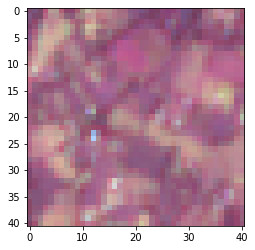

In [8]:
# Look at a sample:
fid = train['Field_ID'].sample().values[0]
fn = f'image_arrays_train/{fid}.npy' # File name based on Field_ID
print(f'Loading {fn} as an array')
arr = np.load(fn) # Loading the data with numpy
print('Array shape:', arr.shape) # 360 bands, images 40 or 41px a side
rgb_jan = np.stack([arr[4], arr[3], arr[2]], axis=-1) # Combine three bands for viewing
rgb_jan = rgb_jan / np.max(rgb_jan) # Scale band values to (0, 1) for easy image display
plt.imshow(rgb_jan) # View with matplotlib

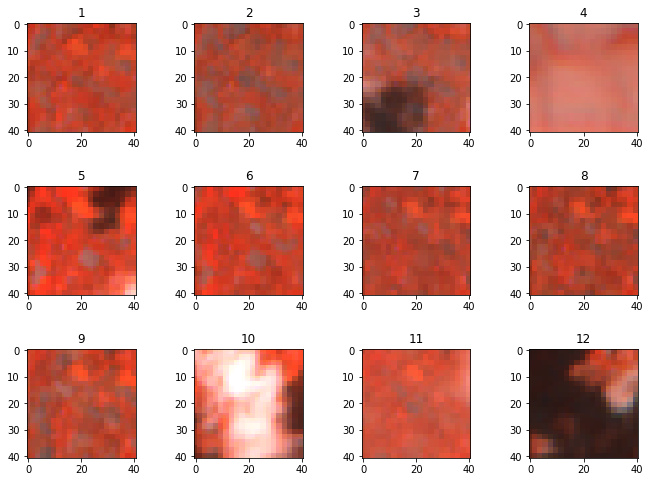

In [9]:
# View false colour images from each month in the year:
fig, axs = plt.subplots(3, 4, figsize=(12, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(12):
  rgb = np.stack([arr[i*30 + 8], arr[i*30 + 4], arr[i*30 + 3]], axis=-1) # False colour (band 8, 4 and 3)
  rgb = rgb / 4000 # Scaling consistently 
  axs[i].imshow(rgb.clip(0, 1))
  axs[i].set_title(str(i+1))

What's with the white fluffy stuff? These are clouds - the bane of all remote sensing analysts...

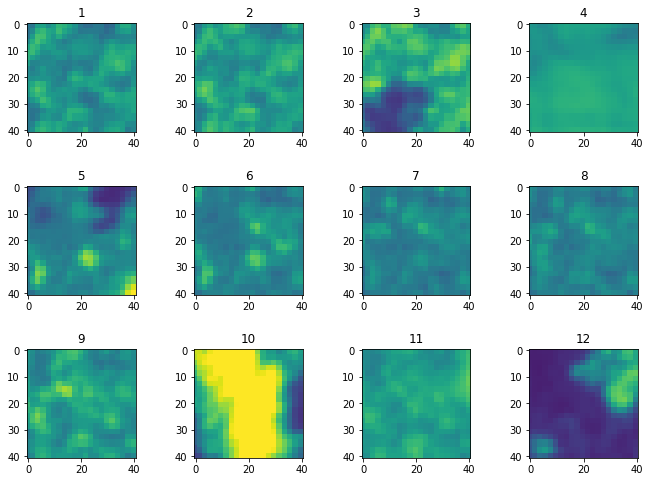

In [10]:
# Show the SWIR band (B12) where clouds have a high reflectance
fig, axs = plt.subplots(3, 4, figsize=(12, 8), facecolor='w', edgecolor='k')
fig.subplots_adjust(hspace = .5, wspace=.001)
axs = axs.ravel()
for i in range(12):
  cloud = arr[i*30 + 11]
  axs[i].imshow(cloud, vmin=0, vmax=4000)
  axs[i].set_title(str(i+1))

# Sampling from the images

There are some hard-coded band indexes in the examples above that won't have made sense - how did we know which bands were which?
There are 30 bands for each month. You can see the full list of bands with:

In [11]:
band_names = [l.strip() for l in open('bandnames.txt', 'r').readlines()]
print(band_names)
#print(len(band_names))

['0_S2_B1', '0_S2_B2', '0_S2_B3', '0_S2_B4', '0_S2_B5', '0_S2_B6', '0_S2_B7', '0_S2_B8', '0_S2_B8A', '0_S2_B9', '0_S2_B10', '0_S2_B11', '0_S2_B12', '0_S2_QA10', '0_S2_QA20', '0_S2_QA60', '0_CLIM_aet', '0_CLIM_def', '0_CLIM_pdsi', '0_CLIM_pet', '0_CLIM_pr', '0_CLIM_ro', '0_CLIM_soil', '0_CLIM_srad', '0_CLIM_swe', '0_CLIM_tmmn', '0_CLIM_tmmx', '0_CLIM_vap', '0_CLIM_vpd', '0_CLIM_vs', '1_S2_B1', '1_S2_B2', '1_S2_B3', '1_S2_B4', '1_S2_B5', '1_S2_B6', '1_S2_B7', '1_S2_B8', '1_S2_B8A', '1_S2_B9', '1_S2_B10', '1_S2_B11', '1_S2_B12', '1_S2_QA10', '1_S2_QA20', '1_S2_QA60', '1_CLIM_aet', '1_CLIM_def', '1_CLIM_pdsi', '1_CLIM_pet', '1_CLIM_pr', '1_CLIM_ro', '1_CLIM_soil', '1_CLIM_srad', '1_CLIM_swe', '1_CLIM_tmmn', '1_CLIM_tmmx', '1_CLIM_vap', '1_CLIM_vpd', '1_CLIM_vs', '2_S2_B1', '2_S2_B2', '2_S2_B3', '2_S2_B4', '2_S2_B5', '2_S2_B6', '2_S2_B7', '2_S2_B8', '2_S2_B8A', '2_S2_B9', '2_S2_B10', '2_S2_B11', '2_S2_B12', '2_S2_QA10', '2_S2_QA20', '2_S2_QA60', '2_CLIM_aet', '2_CLIM_def', '2_CLIM_pdsi', '2

# Fetching Column names for extracking the area of the field from the data

In [12]:
#print(new_band_names)
n = len(band_names)
new_band_names = []
for i in range(n):
    x = band_names[i].split('_',1)[1:]
    y ='_'.join(x)
    new_band_names.append(y)

new_band_names1 = new_band_names[:360]
#print(new_band_names[:360])

0_S2_B1 is band one from the Sentinel 2 image for January (month 0). They're ordered, so we know that the first image band in the array is 0_S2_B1...

You'll likely want to examine specific bands. Here's an example where we create a function to sample the center point (20, 20) for specified bands from each month:

In [13]:
def process_im(fid, folder='image_arrays_train'):
  fn = f'{folder}/{fid}.npy'
  arr = np.load(fn)
  #bands_of_interest = ['S2_B5', 'S2_B4', 'S2_B3', 'S2_B2', 'CLIM_pr', 'CLIM_soil']
  bands_of_interest = new_band_names1
  values = {}
  for month in range(12):
    bns = [str(month) + '_' + b for b in bands_of_interest] # Bands of interest for this month 
    idxs = np.where(np.isin(band_names, bns)) # Index of these bands
    vs = arr[idxs, 20, 20] # Sample the im at the center point
    for bn, v in zip(bns, vs[0]):
      values[bn] = v
  return values

# Example
# process_im('35AFSDD')

With this, we can sample the inputs for each field in train and use that to build a dataframe of input features:

In [14]:
# Make a new DF with the sampled values from each field 
train_sampled = pd.DataFrame([process_im(fid) for fid in train['Field_ID'].values])

# Add in the field ID and yield
train_sampled['Field_ID'] = train['Field_ID'].values
train_sampled['Yield'] = train['Yield'].values
train_sampled.head()

0_S2_B1  0_S2_B2  0_S2_B3  0_S2_B4  0_S2_B5  0_S2_B6  0_S2_B7  0_S2_B8  \
0     1024      934      932     1173     1392     1798     2044     2038   
1     1023      880      821      924     1116     1630     1870     1951   
2     1095     1016     1070     1357     1632     1972     2256     2137   
3      976      777      784      639     1064     2014     2561     2588   
4     1300     1081     1122     1162     1487     2336     2698     2603   

   0_S2_B8A  0_S2_B9  ...  11_CLIM_soil  11_CLIM_srad  11_CLIM_swe  \
0      2327     1072  ...           215          1880            0   
1      2040      929  ...           215          1883            0   
2      2588      957  ...           289          1875            0   
3      2921     1300  ...           189          1898            0   
4      2984      710  ...          1214          1930            0   

   11_CLIM_tmmn  11_CLIM_tmmx  11_CLIM_vap  11_CLIM_vpd  11_CLIM_vs  Field_ID  \
0           100           267         1680           69         210   MH2O0YH   
1            99           273         1682           75         190   O9TURWL   
2           100           274         1690           76         200   35AFSDD   
3            98           263         1688           64         210   PM05EG9   
4           143           291         1972           87         270   V7PZBCG   

   Yield  
0  3.686  
1  5.657  
2  3.082  
3  2.707  
4  2.679  

[5 rows x 362 columns]

In [15]:
train_sampled.to_csv('sample.csv', index = True)

Deleting the unwanted rows for checking the skewness

In [16]:
train_sampled1 = train_sampled.dropna(axis=1)

uniquevalue = []

print(uniquevalue)
type(uniquevalue)

for i in train_sampled1.columns:
    if train_sampled1[i].nunique() == 1:
        del train_sampled1[i]

#del train_sampled1['Field_ID']
train_sampled1.drop(columns = ['0_S2_QA60','1_S2_QA60','2_S2_QA60','3_S2_QA60','3_CLIM_def','3_CLIM_pdsi','4_S2_QA60','5_S2_QA60','6_S2_QA60','7_S2_QA60','8_S2_QA60','9_S2_QA60','10_S2_QA60','11_S2_QA60','4_CLIM_pdsi', '5_CLIM_pdsi', '6_CLIM_pdsi', '7_CLIM_pdsi','8_CLIM_pdsi', '9_CLIM_pdsi', '10_CLIM_pdsi', '11_CLIM_pdsi'], inplace=True)
#print(train_sampled1)
train_sampled1.to_csv('sample1.csv', index = True)
train_sampled1.shape

[]


(2977, 304)

Finding correlation of the data with the target class

In [17]:
train_sampled1.corr()

0_S2_B1   0_S2_B2   0_S2_B3   0_S2_B4   0_S2_B5   0_S2_B6  \
0_S2_B1       1.000000  0.824599  0.750039  0.527370  0.564373  0.305525   
0_S2_B2       0.824599  1.000000  0.951044  0.772900  0.734511  0.283430   
0_S2_B3       0.750039  0.951044  1.000000  0.824434  0.826350  0.395042   
0_S2_B4       0.527370  0.772900  0.824434  1.000000  0.914353  0.009116   
0_S2_B5       0.564373  0.734511  0.826350  0.914353  1.000000  0.242701   
...                ...       ...       ...       ...       ...       ...   
11_CLIM_tmmx  0.188506  0.097495  0.120304 -0.047623  0.016839  0.292439   
11_CLIM_vap   0.275418  0.125891  0.054867 -0.097894 -0.124782  0.097300   
11_CLIM_vpd  -0.006023  0.013553  0.077182  0.061496  0.124463  0.152756   
11_CLIM_vs    0.050159  0.004897  0.054251 -0.045797  0.028704  0.311206   
Yield        -0.072044 -0.010681 -0.008445  0.107324  0.068875 -0.191125   

               0_S2_B7   0_S2_B8  0_S2_B8A   0_S2_B9  ...  11_CLIM_pr  \
0_S2_B1       0.219391  0.198817  0.214266  0.053576  ...    0.008900   
0_S2_B2       0.174712  0.206583  0.181551  0.230760  ...   -0.053843   
0_S2_B3       0.269059  0.323797  0.273497  0.329163  ...   -0.122056   
0_S2_B4      -0.141439 -0.066805 -0.133589  0.552781  ...   -0.193948   
0_S2_B5       0.076164  0.143712  0.085384  0.592995  ...   -0.251109   
...                ...       ...       ...       ...  ...         ...   
11_CLIM_tmmx  0.292306  0.218749  0.292246 -0.211037  ...   -0.413083   
11_CLIM_vap   0.113892  0.049054  0.085861 -0.360490  ...    0.714368   
11_CLIM_vpd   0.134668  0.122080  0.158020  0.069999  ...   -0.829686   
11_CLIM_vs    0.298721  0.244226  0.279645  0.031143  ...   -0.496699   
Yield        -0.205465 -0.154907 -0.193739  0.165770  ...    0.091730   

              11_CLIM_ro  11_CLIM_soil  11_CLIM_srad  11_CLIM_tmmn  \
0_S2_B1         0.022549      0.054306     -0.012560      0.288920   
0_S2_B2        -0.037014     -0.026166      0.022057      0.159328   
0_S2_B3        -0.083230     -0.102406      0.088487      0.155075   
0_S2_B4        -0.176911     -0.222694      0.135461      0.013901   
0_S2_B5        -0.202302     -0.270362      0.188521      0.054092   
...                  ...           ...           ...           ...   
11_CLIM_tmmx   -0.290943     -0.421680      0.610643      0.813482   
11_CLIM_vap     0.523795      0.676039     -0.570642      0.386225   
11_CLIM_vpd    -0.641536     -0.846177      0.942200      0.534652   
11_CLIM_vs     -0.253754     -0.444688      0.564299      0.674688   
Yield          -0.027077      0.051016     -0.165042     -0.359617   

              11_CLIM_tmmx  11_CLIM_vap  11_CLIM_vpd  11_CLIM_vs     Yield  
0_S2_B1           0.188506     0.275418    -0.006023    0.050159 -0.072044  
0_S2_B2           0.097495     0.125891     0.013553    0.004897 -0.010681  
0_S2_B3           0.120304     0.054867     0.077182    0.054251 -0.008445  
0_S2_B4          -0.047623    -0.097894     0.061496   -0.045797  0.107324  
0_S2_B5           0.016839    -0.124782     0.124463    0.028704  0.068875  
...                    ...          ...          ...         ...       ...  
11_CLIM_tmmx      1.000000     0.120992     0.738715    0.712768 -0.325390  
11_CLIM_vap       0.120992     1.000000    -0.524035   -0.031109 -0.174264  
11_CLIM_vpd       0.738715    -0.524035     1.000000    0.621695 -0.173534  
11_CLIM_vs        0.712768    -0.031109     0.621695    1.000000 -0.329681  
Yield            -0.325390    -0.174264    -0.173534   -0.329681  1.000000  

[303 rows x 303 columns]

In [18]:
"""import seaborn as sns
corrMatrix = train_sampled.corr()
plt.figure(figsize=(128, 128))
sns.heatmap(corrMatrix,annot=True)"""

'import seaborn as sns\ncorrMatrix = train_sampled.corr()\nplt.figure(figsize=(128, 128))\nsns.heatmap(corrMatrix,annot=True)'

In [19]:
corrMatrix = train_sampled1.corr()
corrMatrix.to_csv('correlation1.csv', index = True) #saving the correlation values for checking correlation

# Checking the Skewness of Data

In [66]:
train_sampled1.skew(axis = 1, skipna = True)

0       2.311136
1       1.037213
2       2.437013
3       2.461309
4       0.768610
          ...   
2972    0.801159
2973    0.733429
2974    3.124513
2975    0.811658
2976    0.635117
Length: 2977, dtype: float64

Checking skewness Columnwise

In [176]:
skewness = train_sampled1.skew(axis = 0, skipna = True)
print(skewness)
#skewness.to_csv('skewness.csv', index = True)

0_S2_B1         7.043604
0_S2_B2         5.709805
0_S2_B3         3.593708
0_S2_B4         0.863172
0_S2_B5         0.990880
                  ...   
11_CLIM_tmmx   -1.090246
11_CLIM_vap     0.304247
11_CLIM_vpd    -1.380822
11_CLIM_vs     -0.787135
Yield           1.004717
Length: 303, dtype: float64


0_S2_B1
7.04005465949442


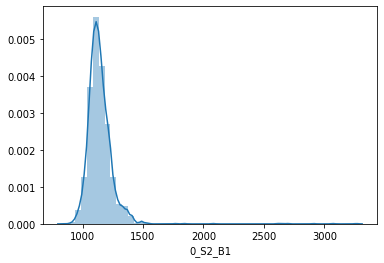

0_S2_B2
5.706927746979349


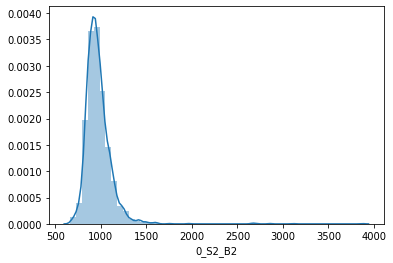

0_S2_B3
3.591897403766666


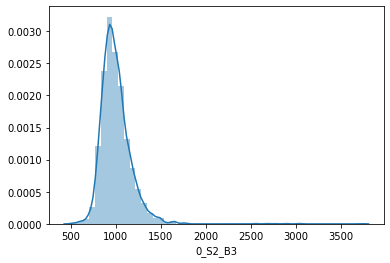

0_S2_B4
0.8627374042278938


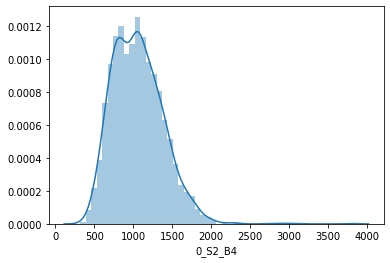

0_S2_B5
0.9903803952965534


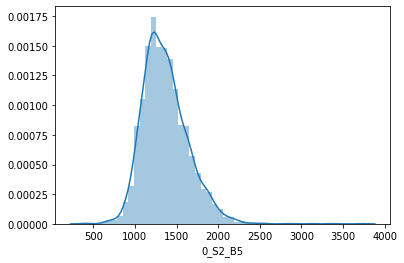

0_S2_B6
0.342387070901775


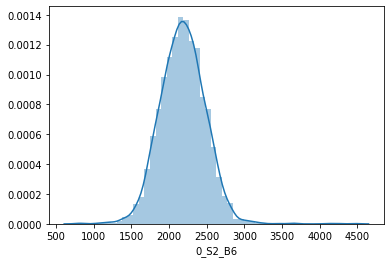

0_S2_B7
0.27556286260746937


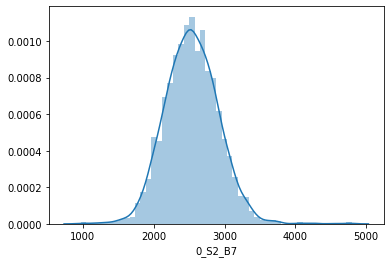

0_S2_B8
0.29409145802339676


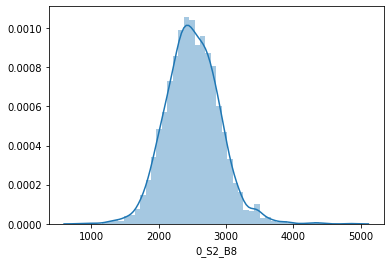

0_S2_B8A
0.09360727305866688


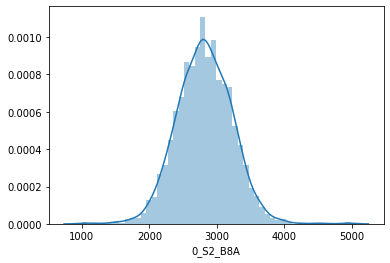

0_S2_B9
0.36995201650854903


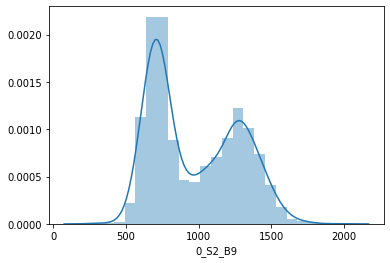

0_S2_B10
2.321117008983006


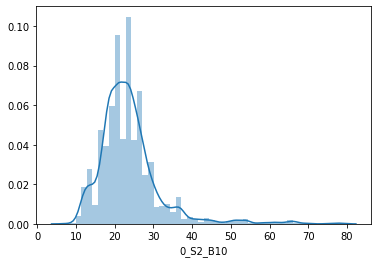

0_S2_B11
0.13956420778375445


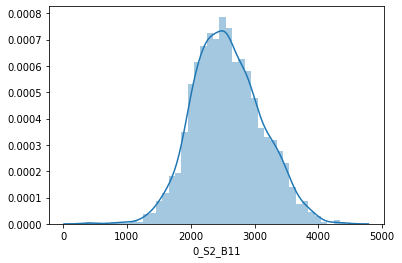

0_S2_B12
0.27454921435544766


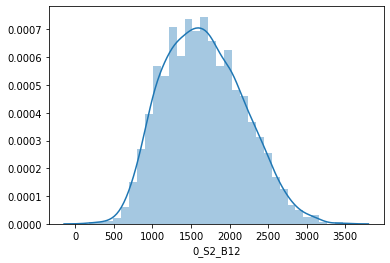

0_CLIM_aet
0.08987941309185317


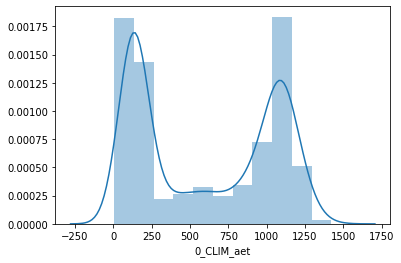

0_CLIM_def
-0.01624029355194757


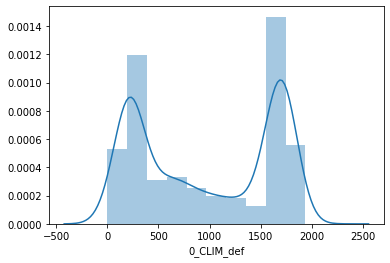

0_CLIM_pdsi
-0.12576651586762744


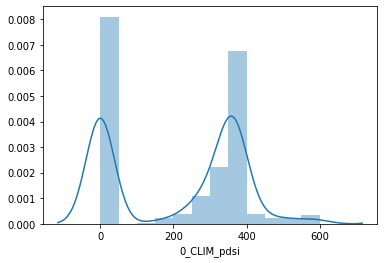

0_CLIM_pet
0.05910472341372173


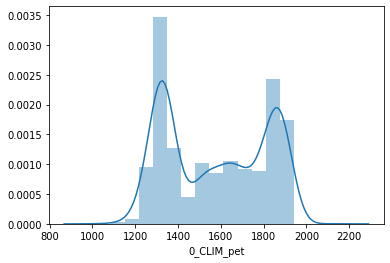

0_CLIM_pr
0.7968129938663439


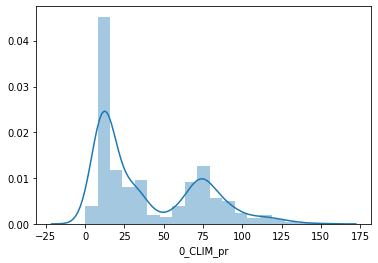

0_CLIM_ro
1.0381869697957216


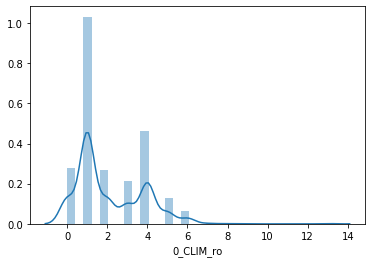

0_CLIM_soil
0.7293938649595825


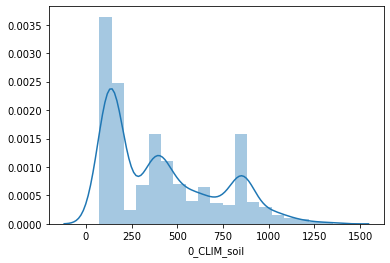

0_CLIM_srad
-0.20077029648797692


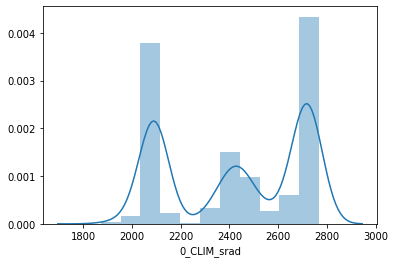

0_CLIM_tmmn
-0.19553043551110189


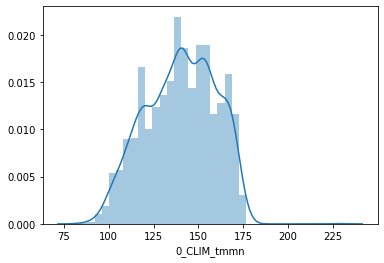

0_CLIM_tmmx
-0.7674513816525855


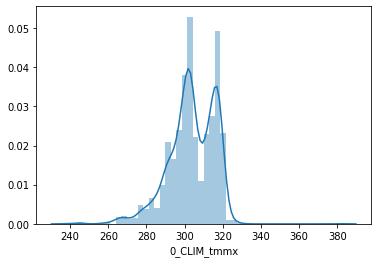

0_CLIM_vap
-0.010426679544378079


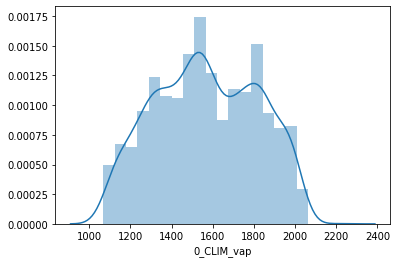

0_CLIM_vpd
-0.21885709366027234


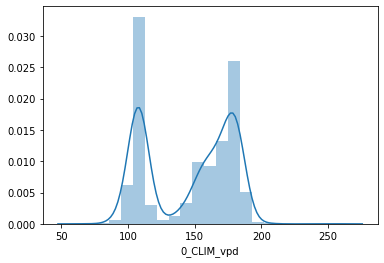

0_CLIM_vs
-0.13847254677337625


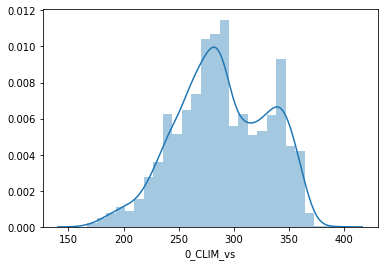

1_S2_B1
9.115376542934237


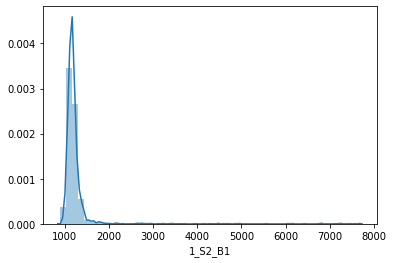

1_S2_B2
9.211766213797132


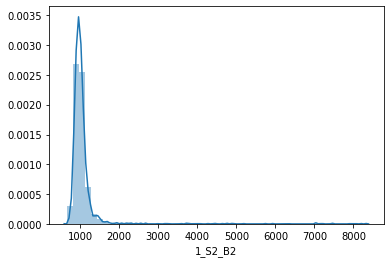

1_S2_B3
8.925061065824005


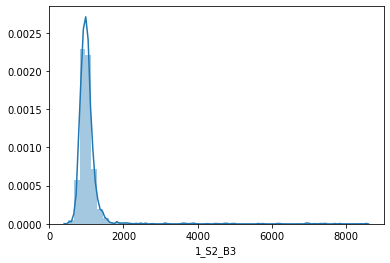

1_S2_B4
7.526005575820734


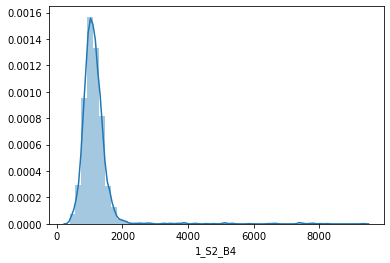

1_S2_B5
7.960834112566375


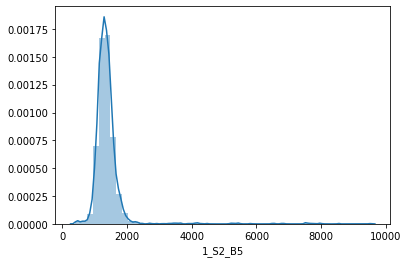

1_S2_B6
5.992766796100943


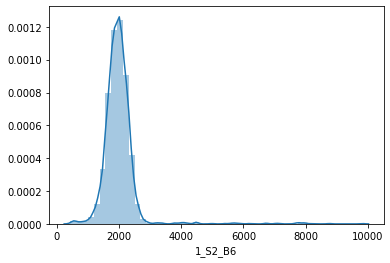

1_S2_B7
4.766397939077078


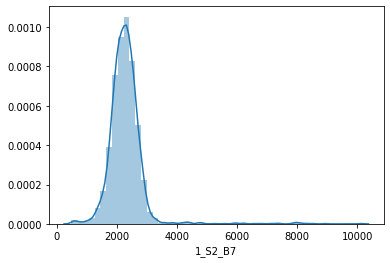

1_S2_B8
4.187075654187987


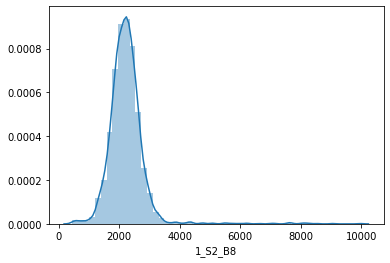

1_S2_B8A
3.9588123388632663


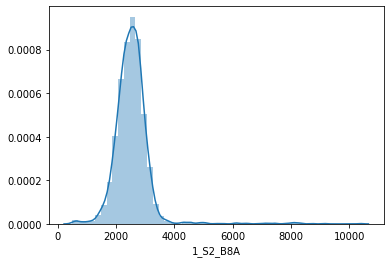

1_S2_B9
5.482109924165629


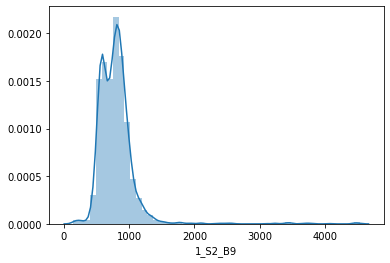

1_S2_B10
7.881919696879187


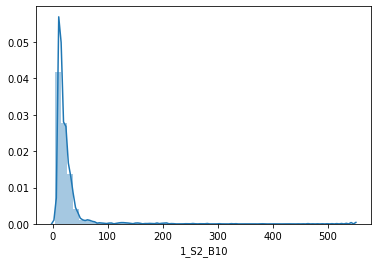

1_S2_B11
1.5630842653005113


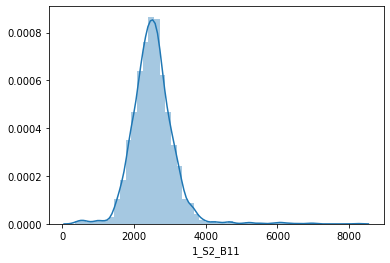

1_S2_B12
1.682900246315546


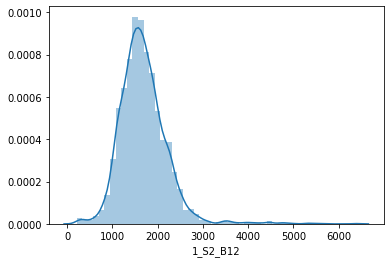

1_CLIM_aet
0.5561267575908535


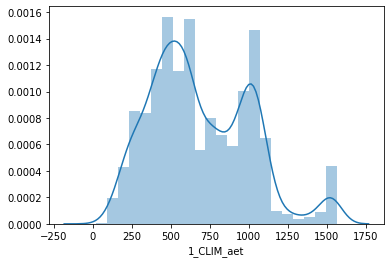

1_CLIM_def
-0.4307770079009351


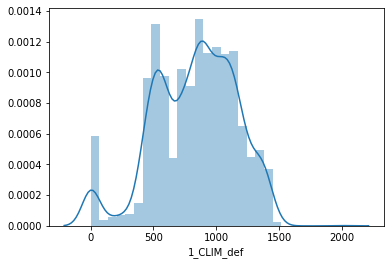

1_CLIM_pdsi
0.15265724047037202


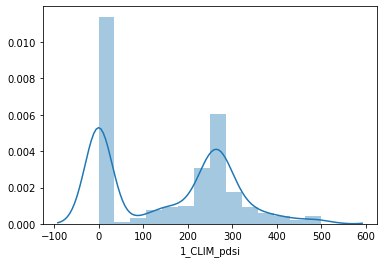

1_CLIM_pet
0.06898219482485832


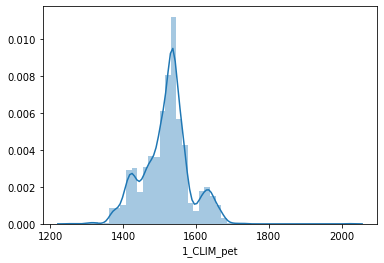

1_CLIM_pr
0.9977497831872354


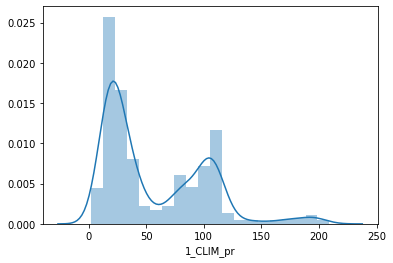

1_CLIM_ro
1.0361646134766143


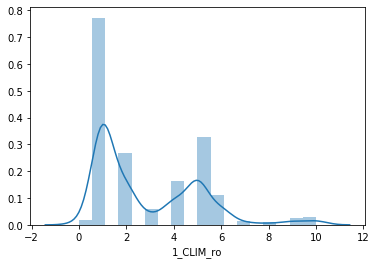

1_CLIM_soil
0.9671217429266155


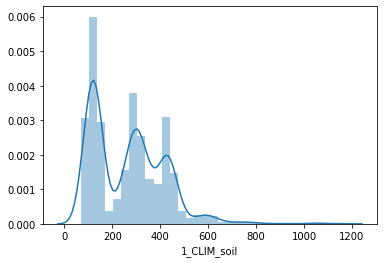

1_CLIM_srad
0.8172176509838925


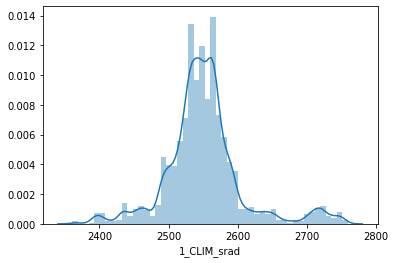

1_CLIM_tmmn
-0.2661375778395729


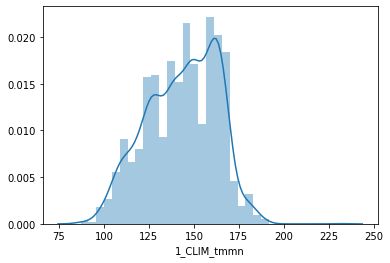

1_CLIM_tmmx
-0.39357894237140534


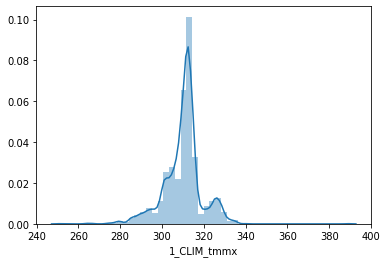

1_CLIM_vap
-0.36334760292805257


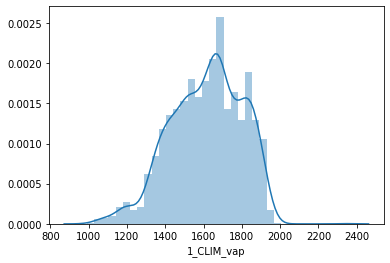

1_CLIM_vpd
1.8696998240473175


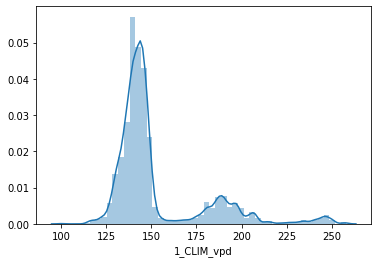

1_CLIM_vs
-0.8939448311146497


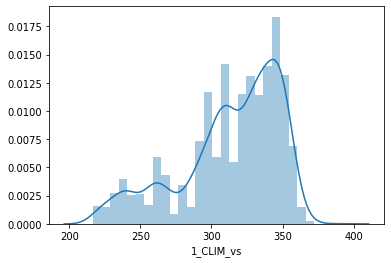

2_S2_B1
3.8265811862174512


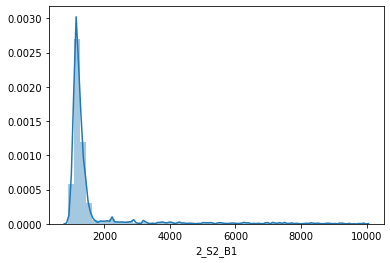

2_S2_B2
3.9233486634121055


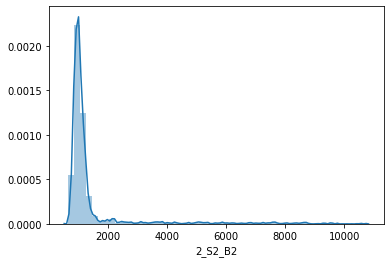

2_S2_B3
3.9209726552545385


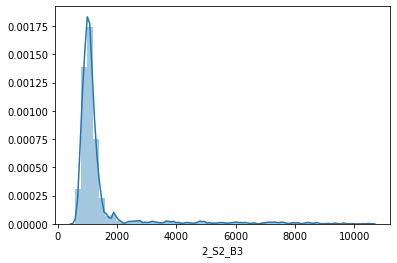

2_S2_B4
3.805462344026427


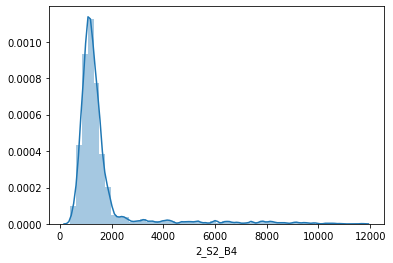

2_S2_B5
3.8767788525394864


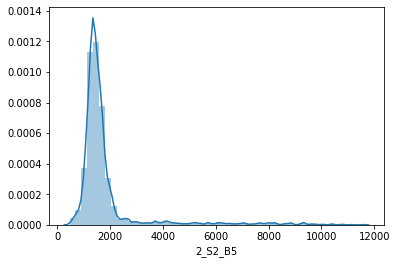

2_S2_B6
3.5137521758898655


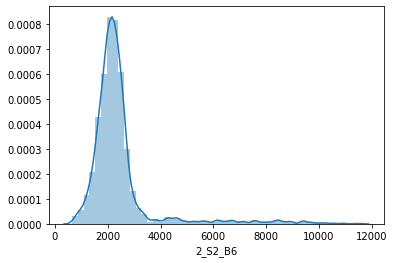

2_S2_B7
3.246715551551924


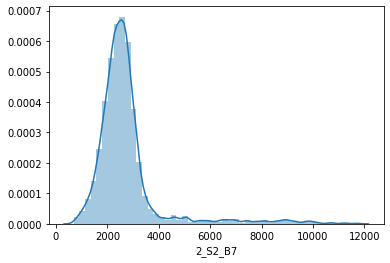

2_S2_B8
3.1606177549593832


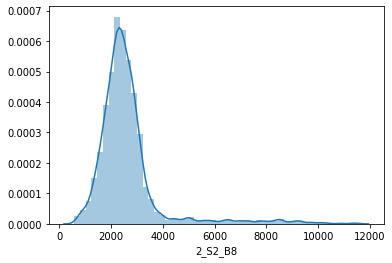

2_S2_B8A
3.0369362939205944


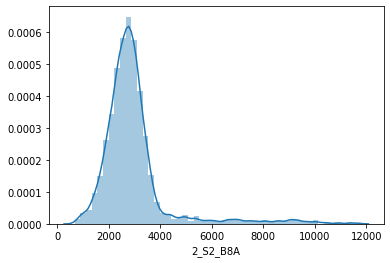

2_S2_B9
4.623279181642886


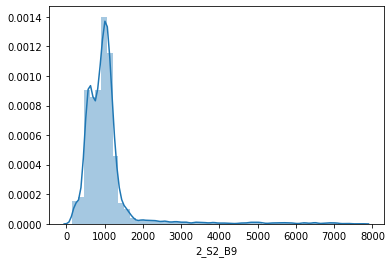

2_S2_B10
8.17081657070158


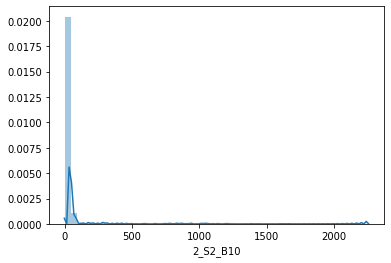

2_S2_B11
1.6058005318075343


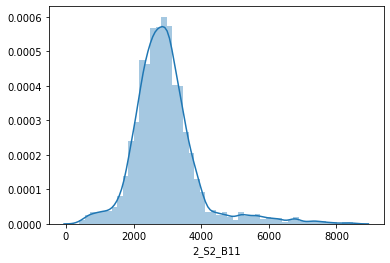

2_S2_B12
1.4608669317502345


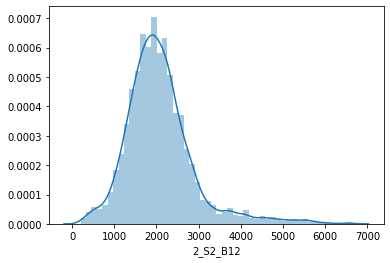

2_CLIM_aet
0.6046495575995332


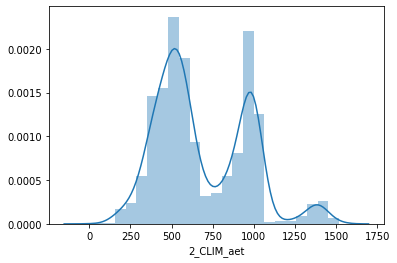

2_CLIM_def
-0.8156669202170331


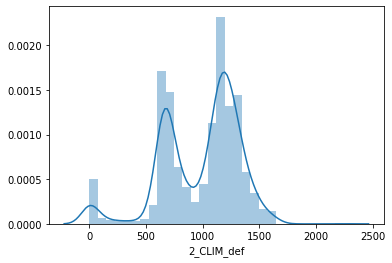

2_CLIM_pdsi
1.5119226383087117


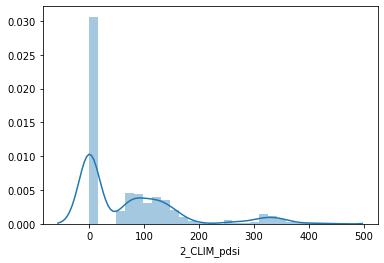

2_CLIM_pet
-1.7957730862351757


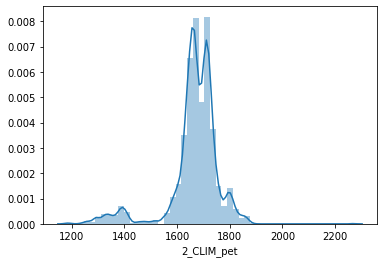

2_CLIM_pr
0.8330279000068882


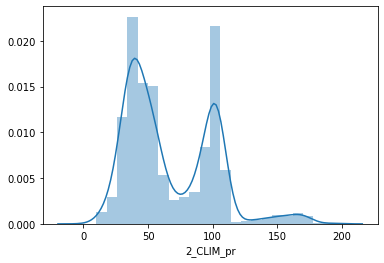

2_CLIM_ro
9.87321128413732


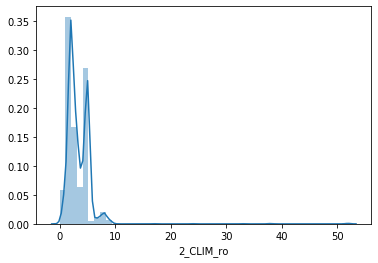

2_CLIM_soil
3.018291943686963


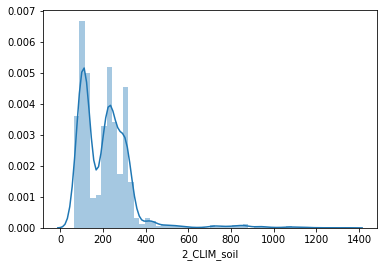

2_CLIM_srad
-2.4906383225987705


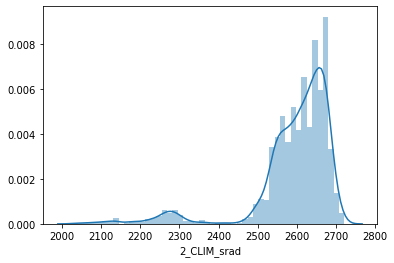

2_CLIM_tmmn
-0.2733822710403955


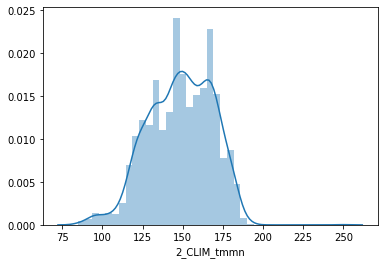

2_CLIM_tmmx
-1.4733511496151541


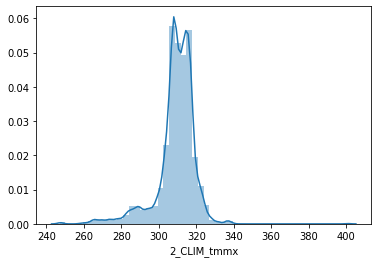

2_CLIM_vap
-0.40248628391243996


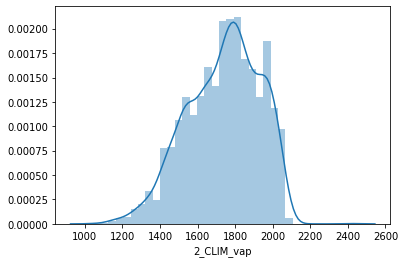

2_CLIM_vpd
-0.33974490234104693


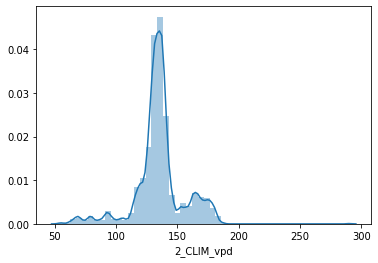

2_CLIM_vs
-0.8387230449428287


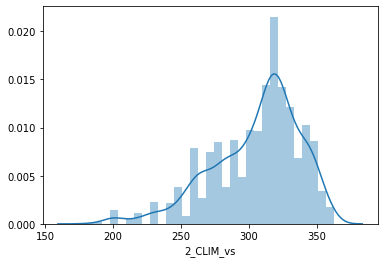

3_S2_B1
3.0923133893308417


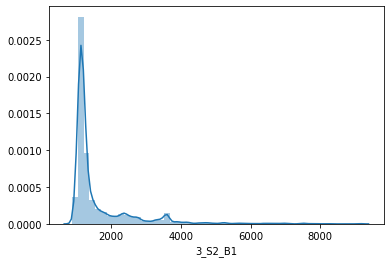

3_S2_B2
3.3320971666056156


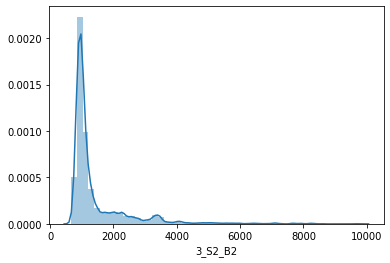

3_S2_B3
3.483220102394451


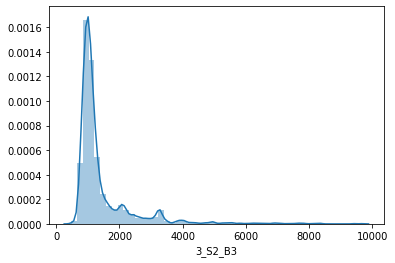

3_S2_B4
3.574854368167452


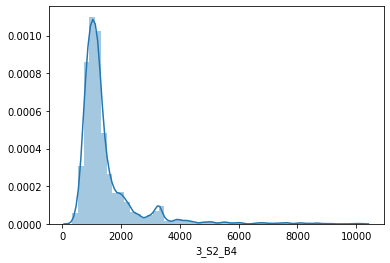

3_S2_B5
3.60936892162944


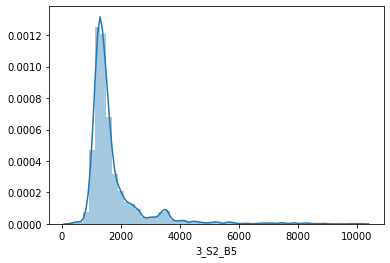

3_S2_B6
2.9189745220127925


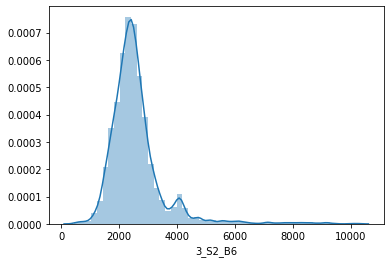

3_S2_B7
2.490523069912837


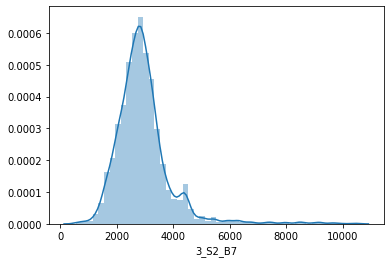

3_S2_B8
2.3796773979746204


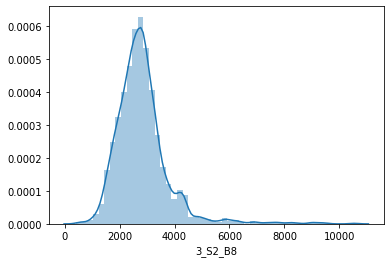

3_S2_B8A
2.3182358089845723


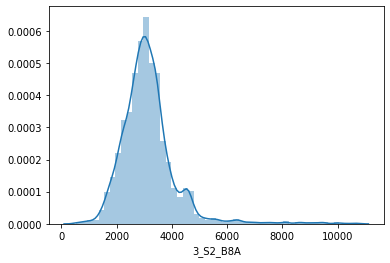

3_S2_B9
2.517171234101305


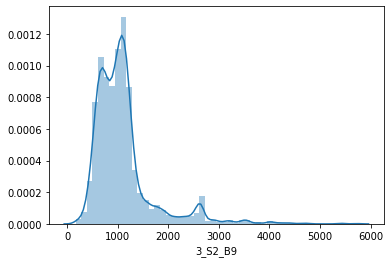

3_S2_B10
2.2499191351213303


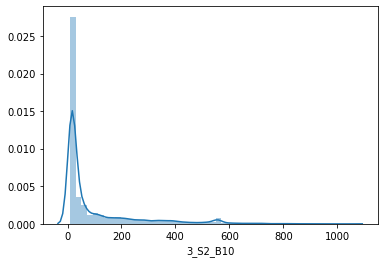

3_S2_B11
1.931987129053524


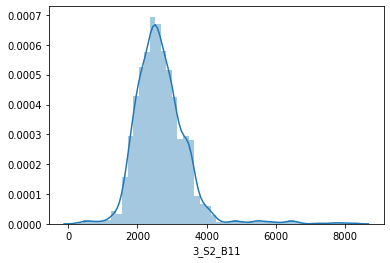

3_S2_B12
1.630689277602245


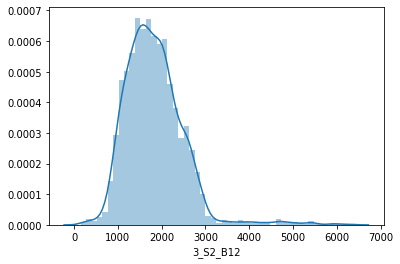

3_CLIM_aet
-0.27835821680219325


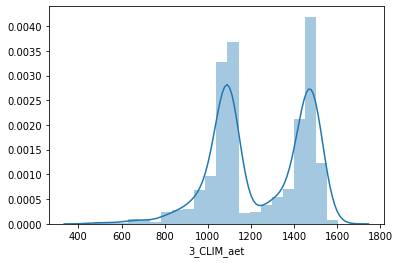

3_CLIM_pet
-0.3711846308141338


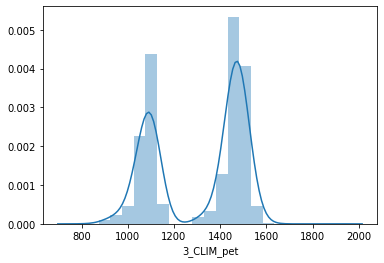

3_CLIM_pr
0.4134178269602049


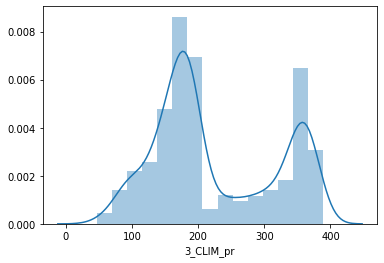

3_CLIM_ro
0.8843056600809972


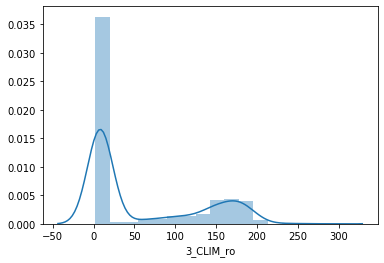

3_CLIM_soil
0.32197164056344046


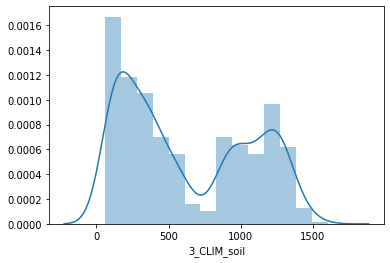

3_CLIM_srad
-0.31655139103058183


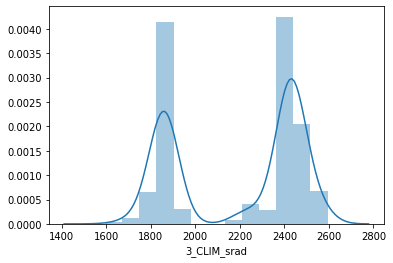

3_CLIM_tmmn
-0.281812273469181


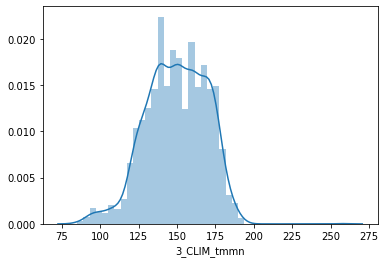

3_CLIM_tmmx
-1.2982324002435837


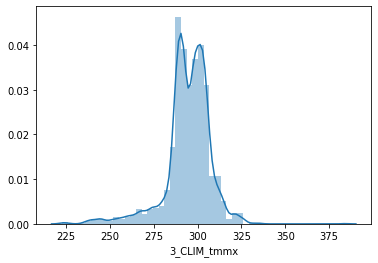

3_CLIM_vap
-0.390819476250741


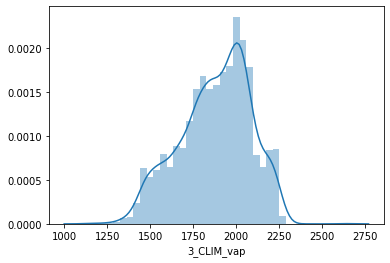

3_CLIM_vpd
-0.22534923207439192


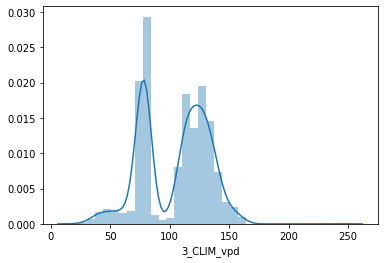

3_CLIM_vs
-0.39295805941061646


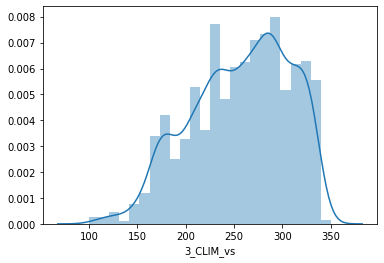

4_S2_B1
5.056940239080133


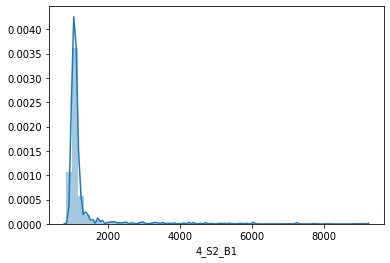

4_S2_B2
4.973585409003274


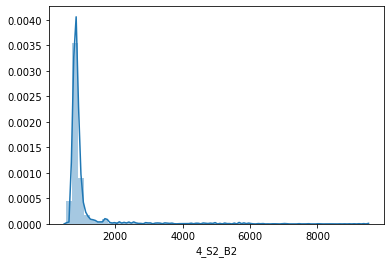

4_S2_B3
4.9635328263912655


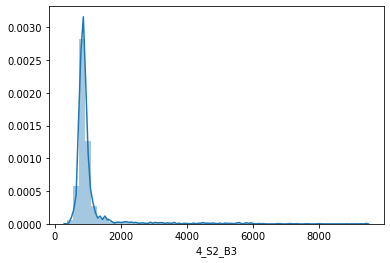

4_S2_B4
4.716789712656443


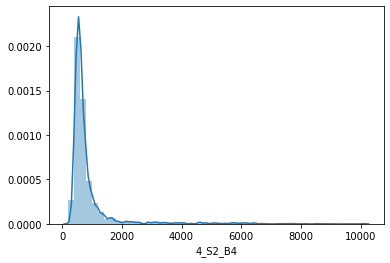

4_S2_B5
4.726459097705416


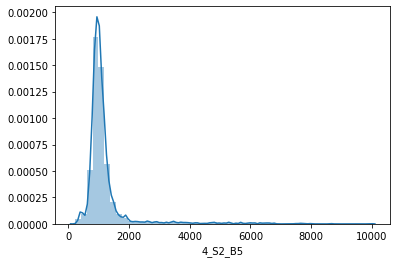

4_S2_B6
2.637699064572615


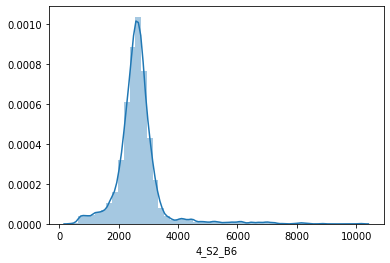

4_S2_B7
1.44325626150888


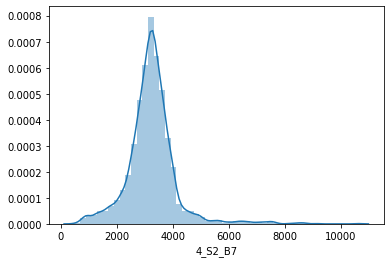

4_S2_B8
1.191047768047161


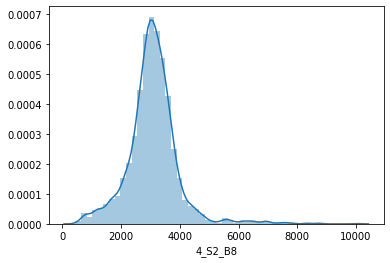

4_S2_B8A
1.1639257364956799


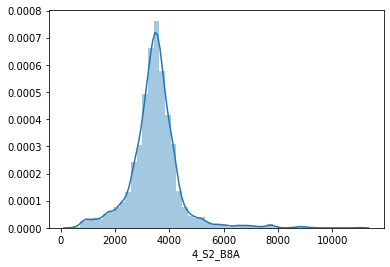

4_S2_B9
4.219509189436446


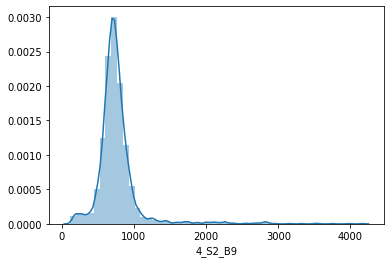

4_S2_B10
5.296869857667353


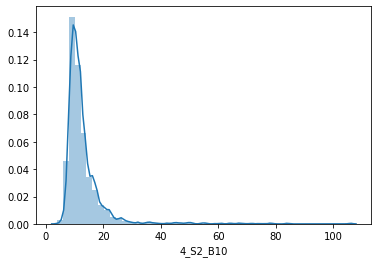

4_S2_B11
2.7949054252372294


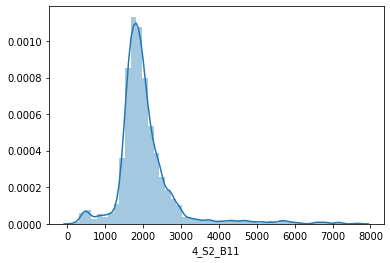

4_S2_B12
3.206489192505203


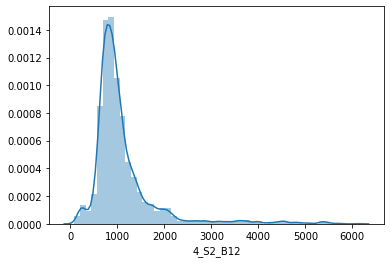

4_CLIM_aet
-0.707499385537568


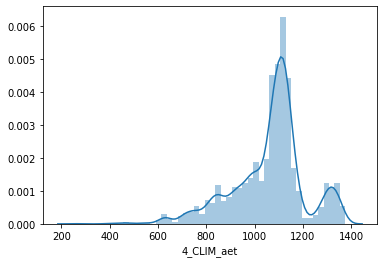

4_CLIM_def
1.3039831570492724


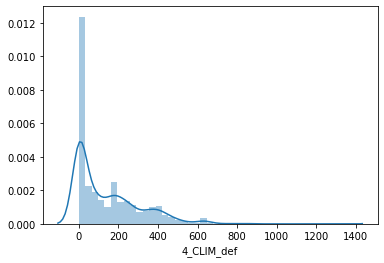

4_CLIM_pet
-0.4081809481802193


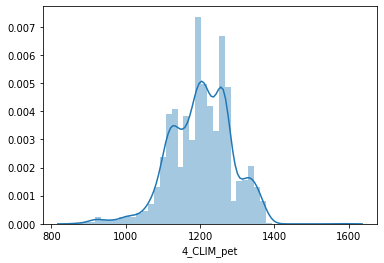

4_CLIM_pr
3.1207212915430476


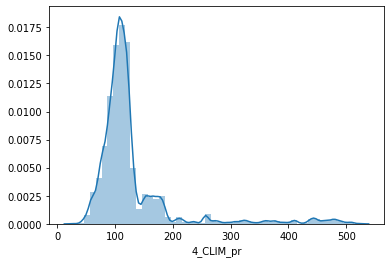

4_CLIM_ro
4.215017529293642


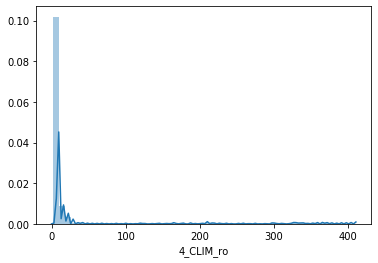

4_CLIM_soil
0.3081801491246695


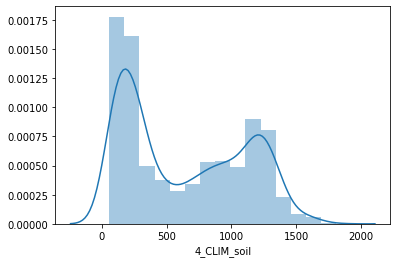

4_CLIM_srad
-1.1196420177237274


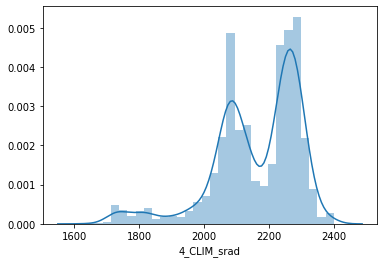

4_CLIM_tmmn
-0.0966499484088795


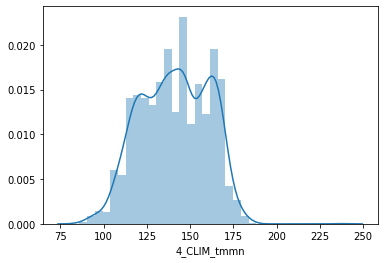

4_CLIM_tmmx
-1.4105722741105808


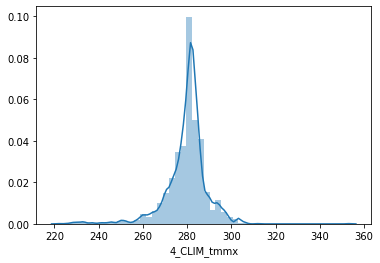

4_CLIM_vap
-0.5341707418954059


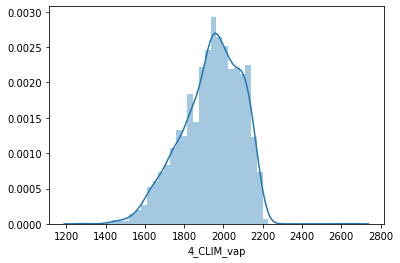

4_CLIM_vpd
-0.7254964106143585


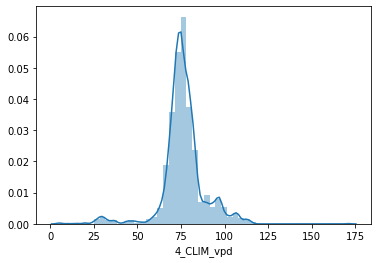

4_CLIM_vs
-0.12718543224945483


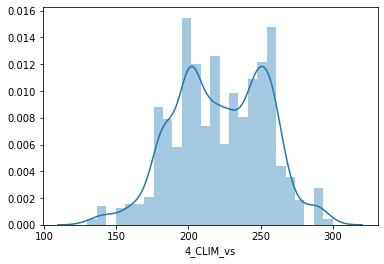

5_S2_B1
6.132611994037817


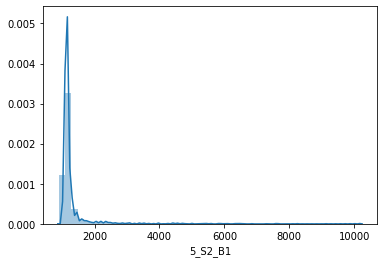

5_S2_B2
6.176120260507184


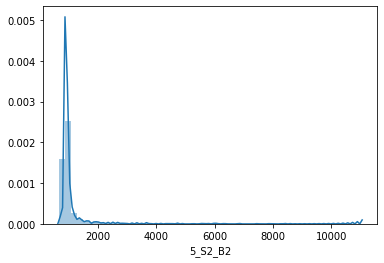

5_S2_B3
6.23887966537069


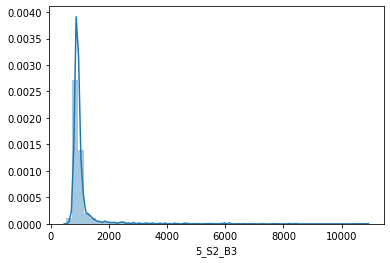

5_S2_B4
5.943964313388563


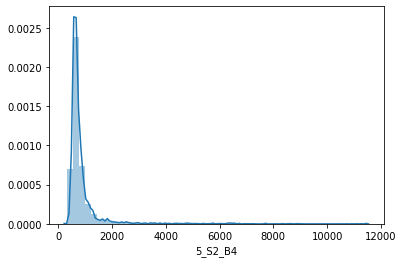

5_S2_B5
6.0566109416725045


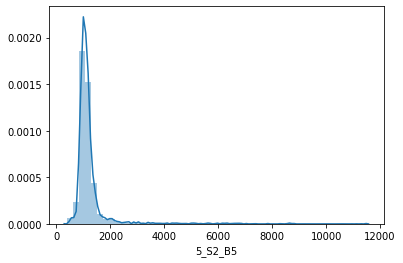

5_S2_B6
4.392399784593432


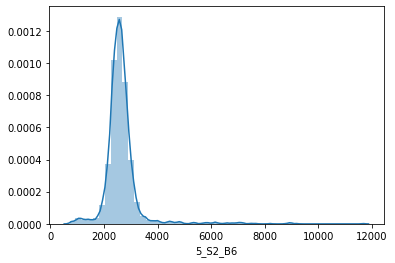

5_S2_B7
3.018790511718121


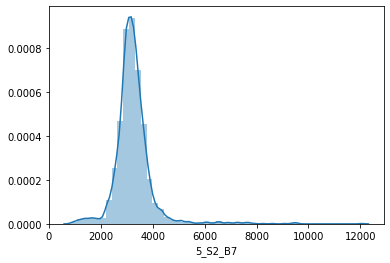

5_S2_B8
2.7644107245122975


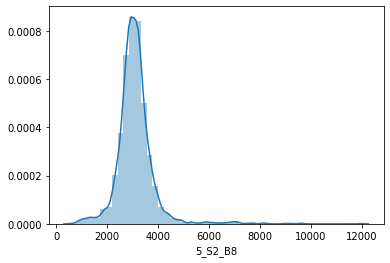

5_S2_B8A
2.5849788627186134


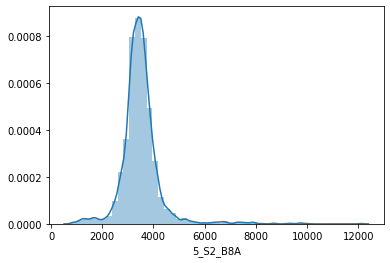

5_S2_B9
4.738610334785977


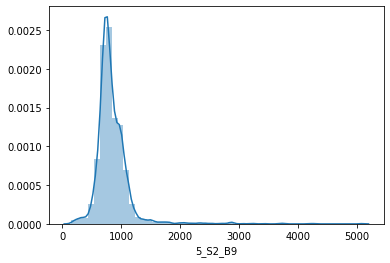

5_S2_B10
7.042307207874874


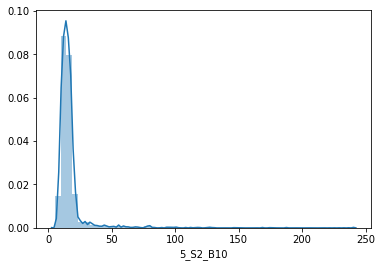

5_S2_B11
3.269531684618428


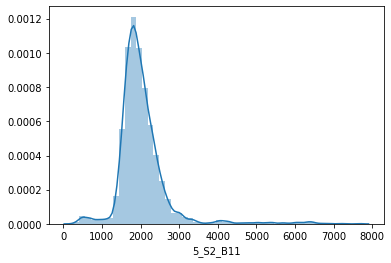

5_S2_B12
3.447658520643945


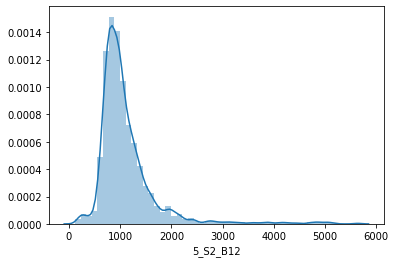

5_CLIM_aet
0.03210155104534589


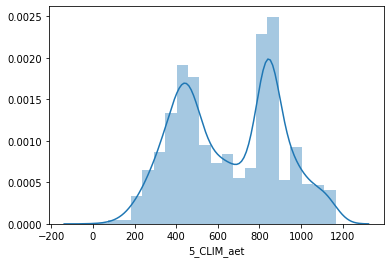

5_CLIM_def
-0.14466574230045867


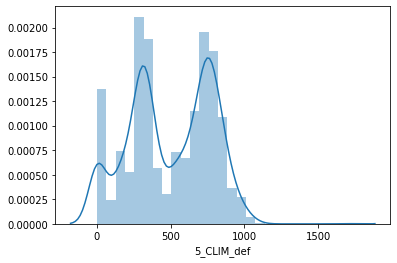

5_CLIM_pet
-1.8255726033335777


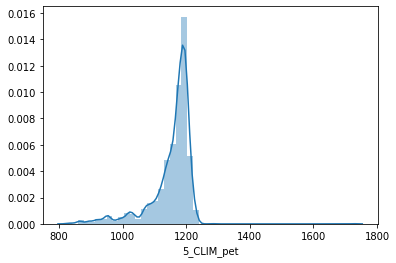

5_CLIM_pr
3.431050328662907


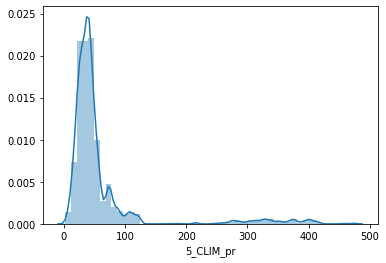

5_CLIM_ro
3.9824638188636197


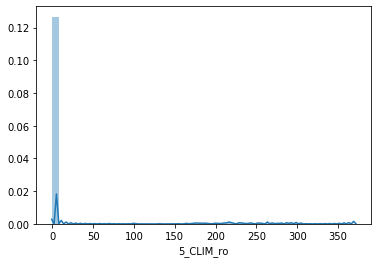

5_CLIM_soil
1.1608254013181558


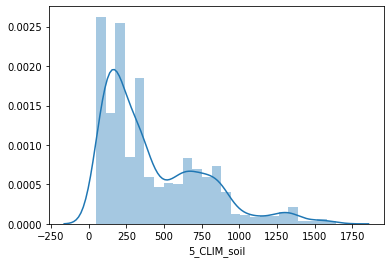

5_CLIM_srad
-2.7291964001696996


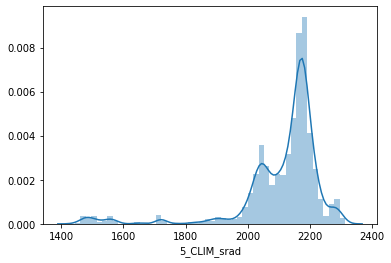

5_CLIM_tmmn
-0.18335351528274427


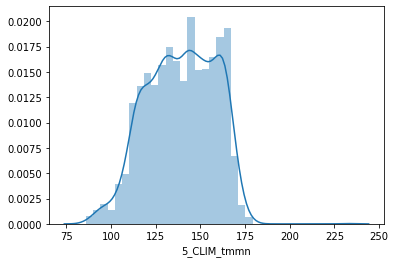

5_CLIM_tmmx
-1.3582354461719275


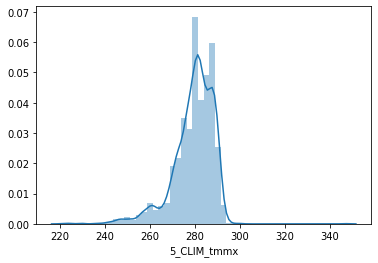

5_CLIM_vap
-0.33543380206149903


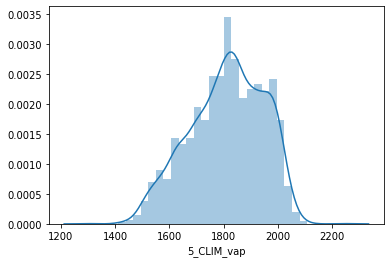

5_CLIM_vpd
-1.03448655553285


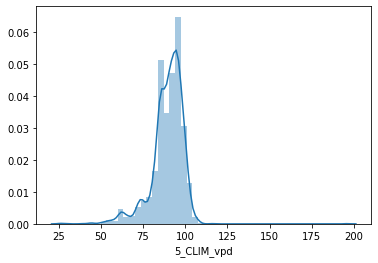

5_CLIM_vs
-0.14303592901515894


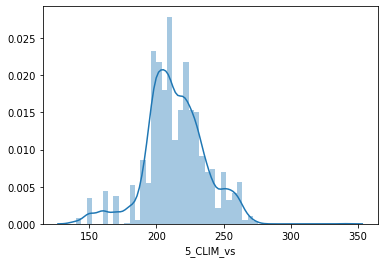

6_S2_B1
5.608922661798775


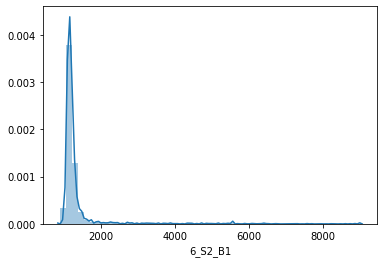

6_S2_B2
5.624303459704369


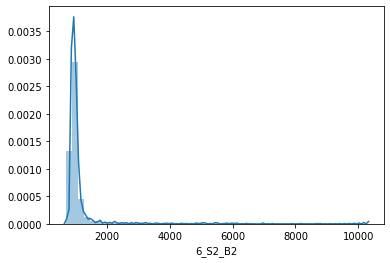

6_S2_B3
5.669246737362774


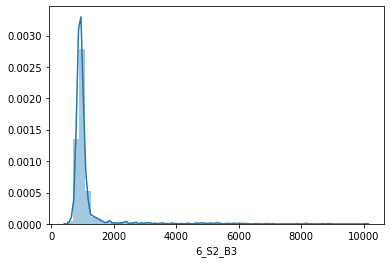

6_S2_B4
5.355617889160829


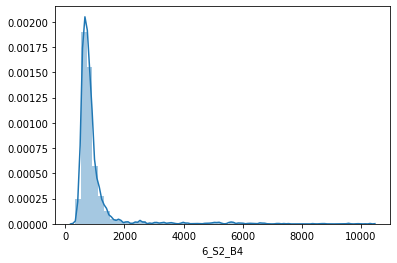

6_S2_B5
5.445063465047051


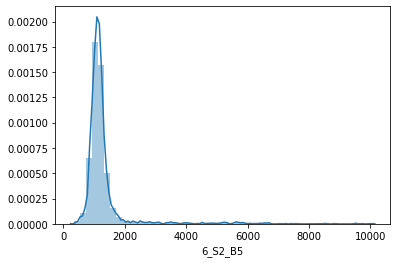

6_S2_B6
4.190224478899814


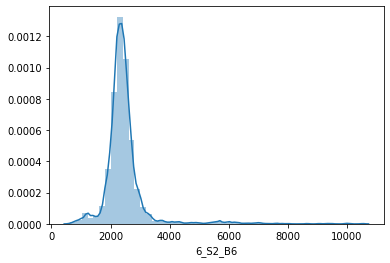

6_S2_B7
3.1109190221606426


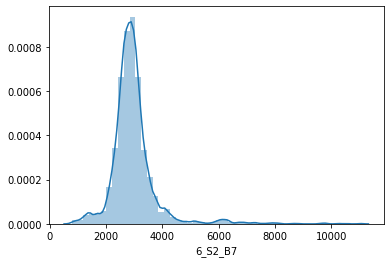

6_S2_B8
2.9744304967938193


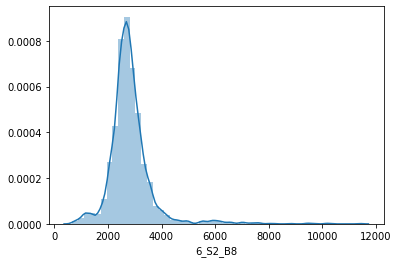

6_S2_B8A
2.716481009753802


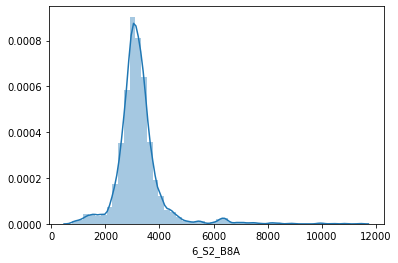

6_S2_B9
5.759551489365558


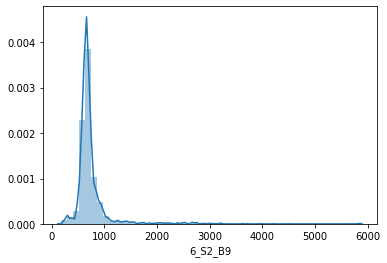

6_S2_B10
5.154298321294302


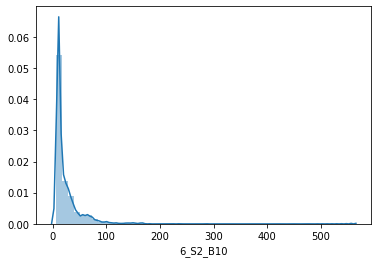

6_S2_B11
2.8712829900090395


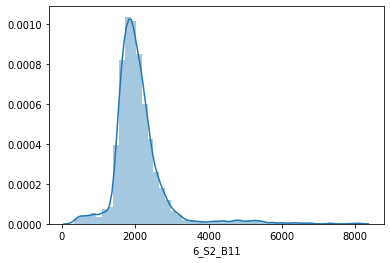

6_S2_B12
3.2133012653160327


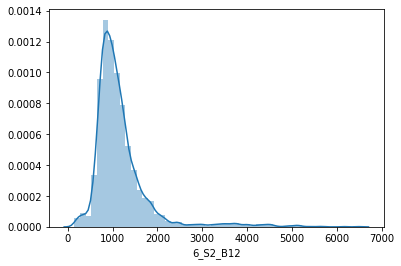

6_CLIM_aet
0.4590948151084653


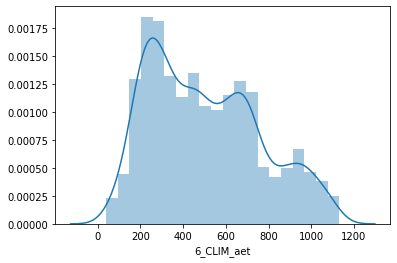

6_CLIM_def
-0.4992761781044002


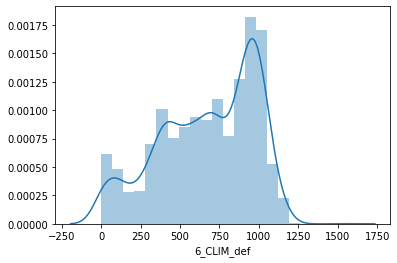

6_CLIM_pet
-0.7319877772639555


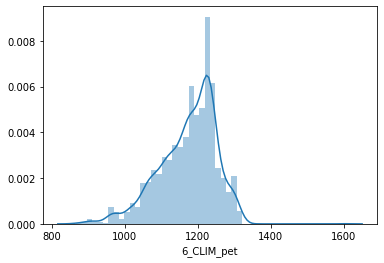

6_CLIM_pr
1.1133520138031017


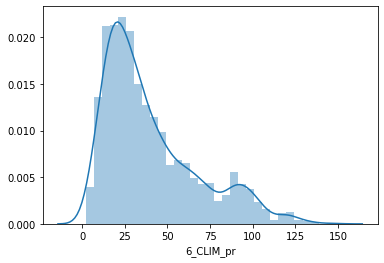

6_CLIM_ro
6.699380400931935


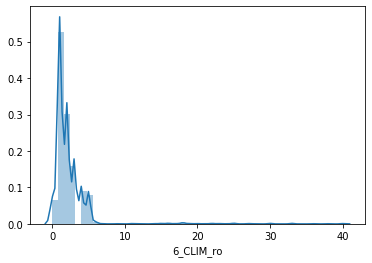

6_CLIM_soil
2.489620139009913


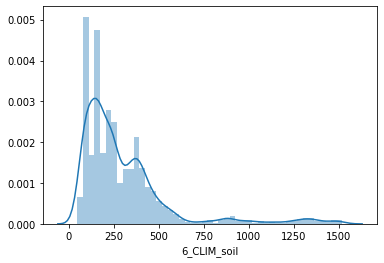

6_CLIM_srad
0.40514175285475396


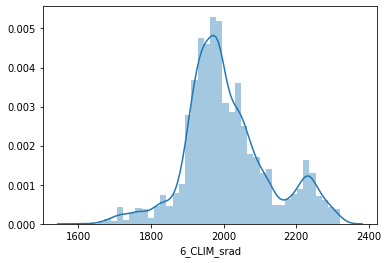

6_CLIM_tmmn
-0.18841144619057001


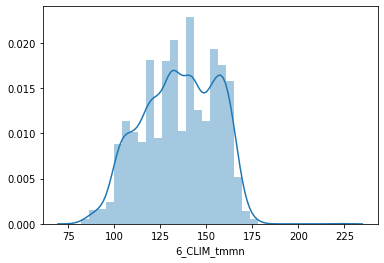

6_CLIM_tmmx
-1.6750290098672396


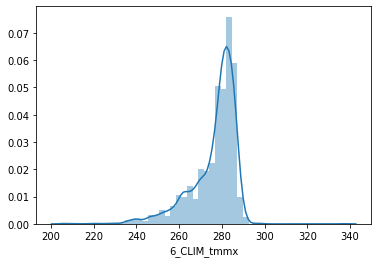

6_CLIM_vap
-0.30623737235918813


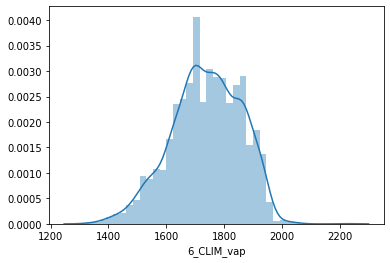

6_CLIM_vpd
-0.6388735531045904


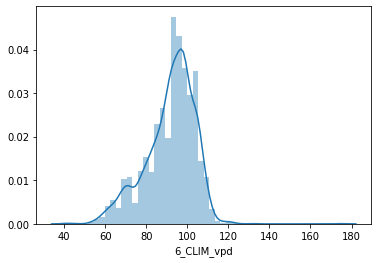

6_CLIM_vs
-0.41821114981949165


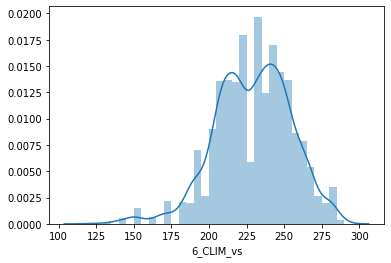

7_S2_B1
8.9530904165258


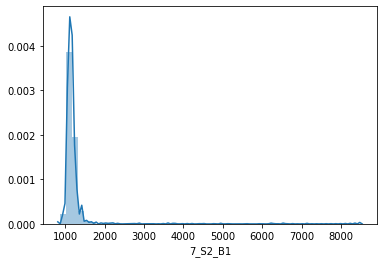

7_S2_B2
8.875320095091332


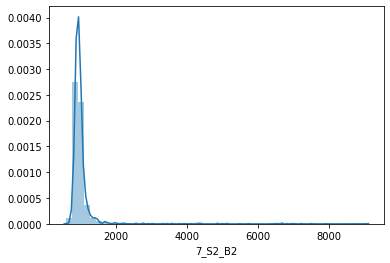

7_S2_B3
8.798481263742604


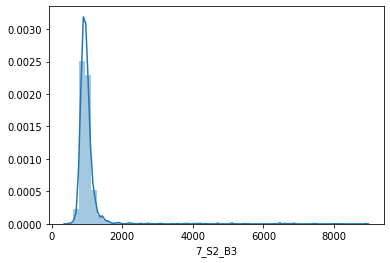

7_S2_B4
7.685008357621953


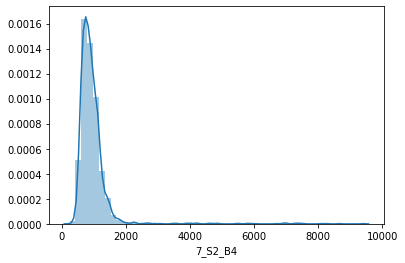

7_S2_B5
8.289946043833805


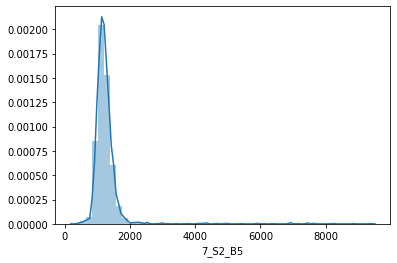

7_S2_B6
5.523203153138867


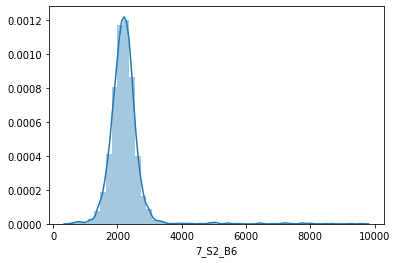

7_S2_B7
3.9478977240999704


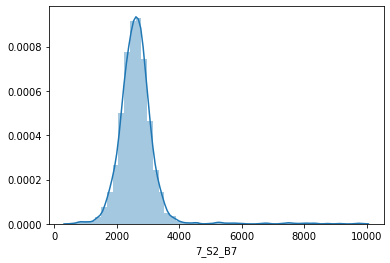

7_S2_B8
3.28997459299421


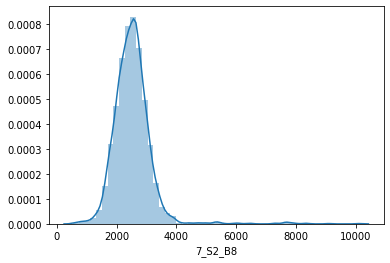

7_S2_B8A
3.315062479375778


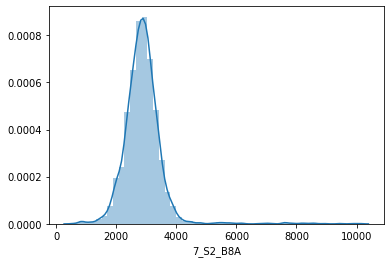

7_S2_B9
6.275436252414247


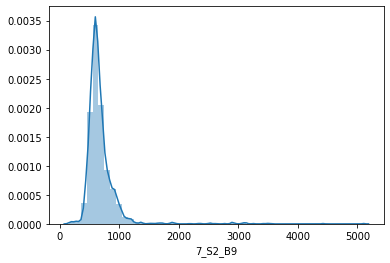

7_S2_B10
14.22624631508398


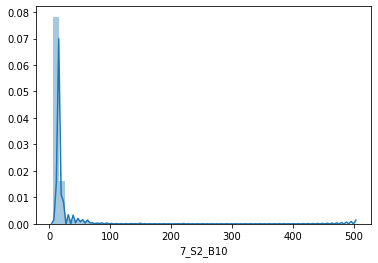

7_S2_B11
3.2776053439685864


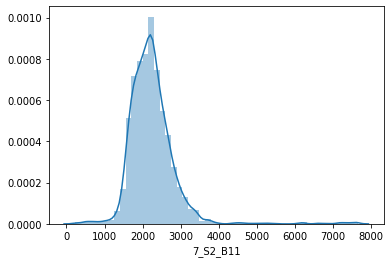

7_S2_B12
3.3338604790922974


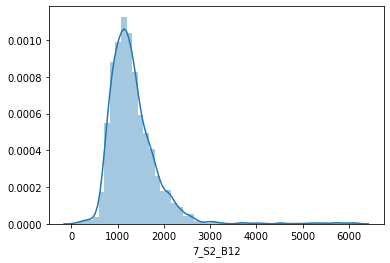

7_CLIM_aet
-0.37946116902663257


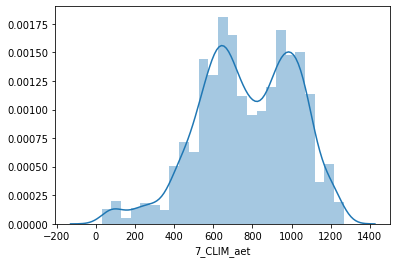

7_CLIM_def
0.32136093876419214


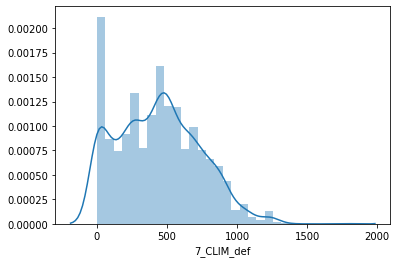

7_CLIM_pet
-0.040726192601920445


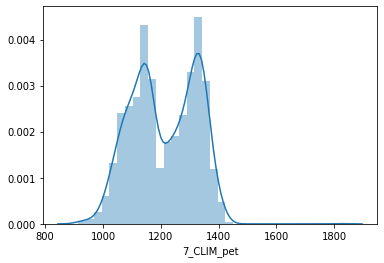

7_CLIM_pr
2.6338416048154225


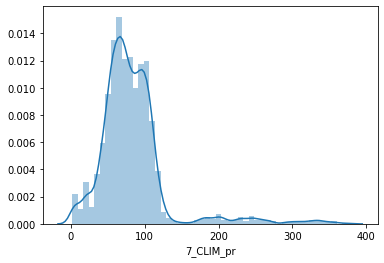

7_CLIM_ro
5.404622116885444


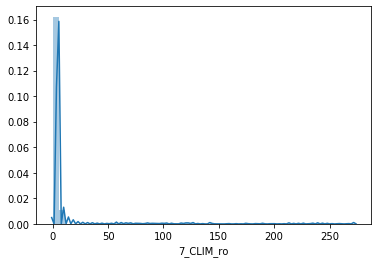

7_CLIM_soil
3.160827259618098


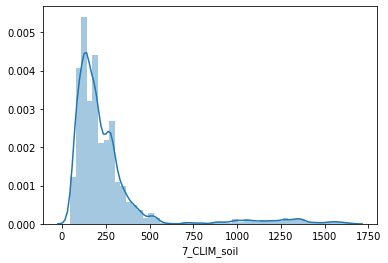

7_CLIM_srad
-0.14966669491637075


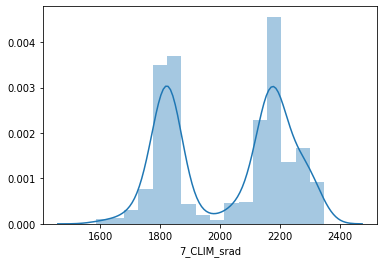

7_CLIM_tmmn
-0.29138529558491366


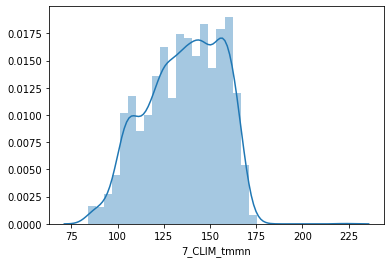

7_CLIM_tmmx
-1.529990181458316


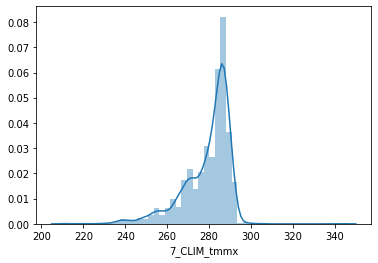

7_CLIM_vap
-0.09116913480686681


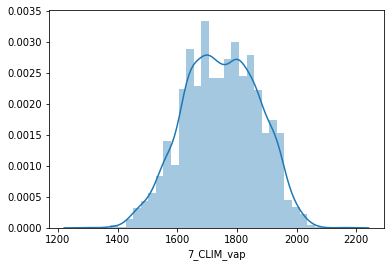

7_CLIM_vpd
-0.3849198681051451


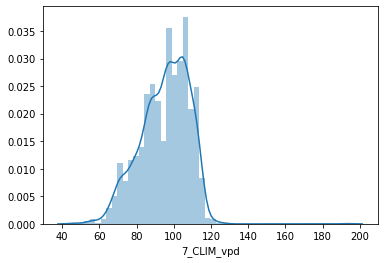

7_CLIM_vs
-0.08969771834383412


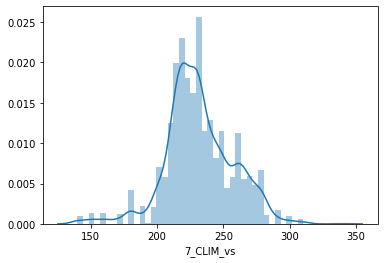

8_S2_B1
7.0327121438863545


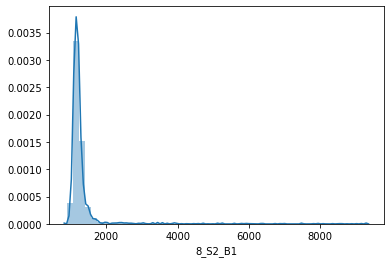

8_S2_B2
7.032390620972294


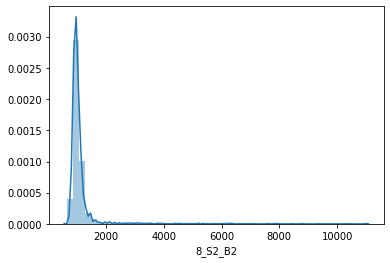

8_S2_B3
6.99353252503865


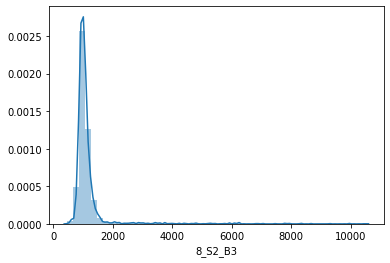

8_S2_B4
6.119292260190846


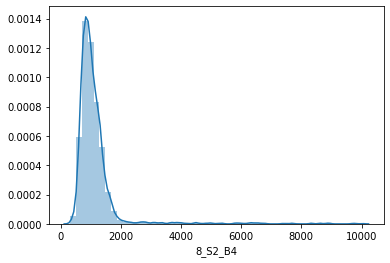

8_S2_B5
6.492150377440369


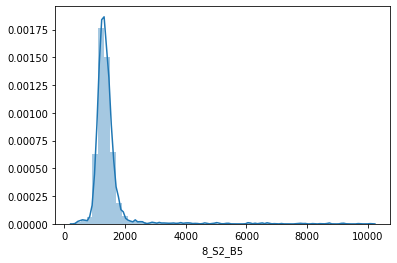

8_S2_B6
4.866913305881365


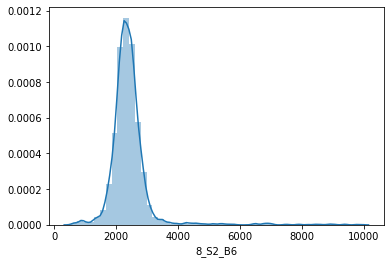

8_S2_B7
3.8771762404586516


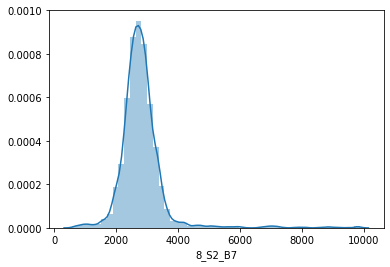

8_S2_B8
3.7979170549926122


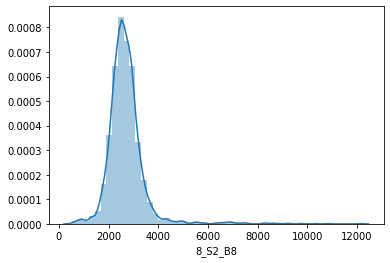

8_S2_B8A
3.3194778435004877


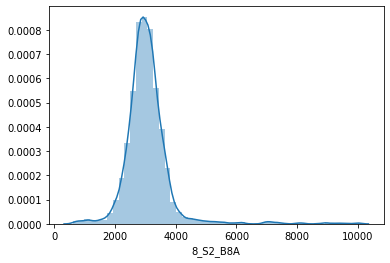

8_S2_B9
6.424200942918076


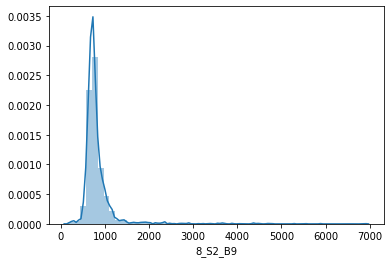

8_S2_B10
9.456347772144008


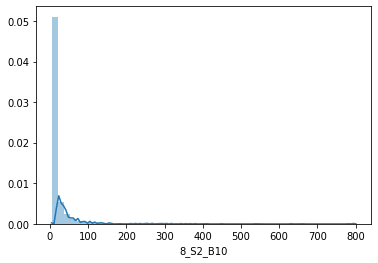

8_S2_B11
2.164723190811652


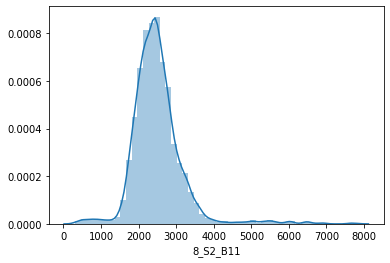

8_S2_B12
2.279848611790373


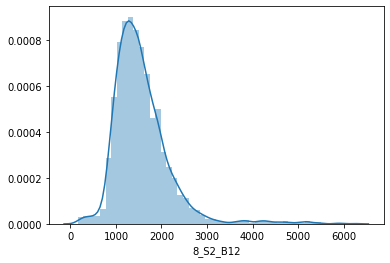

8_CLIM_aet
-0.41742943511274516


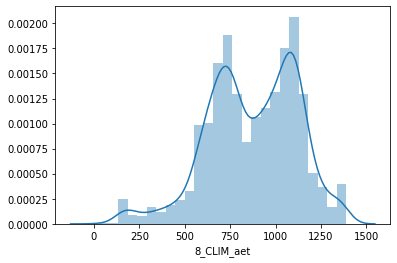

8_CLIM_def
0.5000101429809409


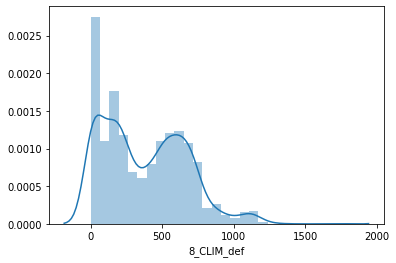

8_CLIM_pet
-0.06304621562226925


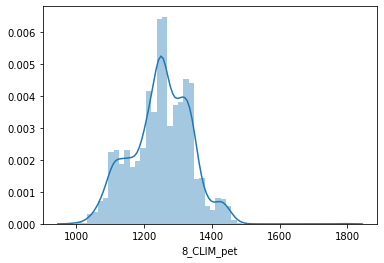

8_CLIM_pr
0.44809648249506406


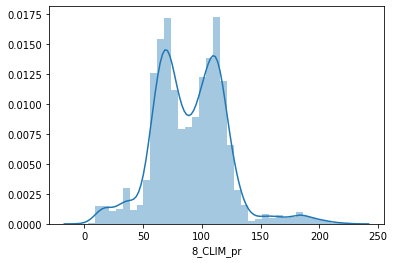

8_CLIM_ro
5.942485411802597


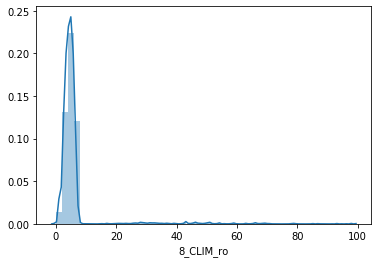

8_CLIM_soil
3.392217754434569


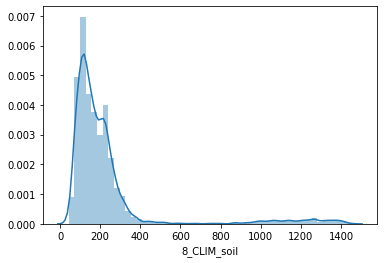

8_CLIM_srad
0.6299652721564902


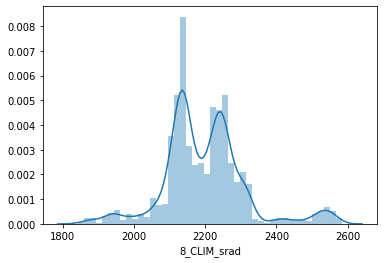

8_CLIM_tmmn
-0.29001734464751205


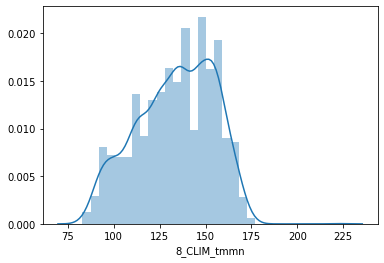

8_CLIM_tmmx
-0.9048517746351102


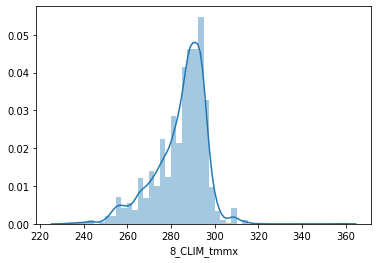

8_CLIM_vap
-0.0704793149044745


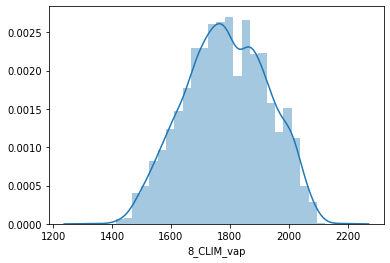

8_CLIM_vpd
0.04953490688545899


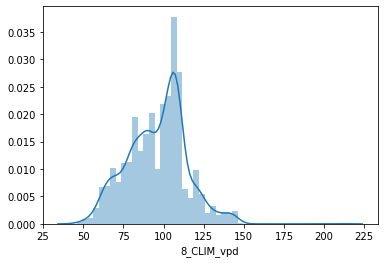

8_CLIM_vs
-0.009150278770067867


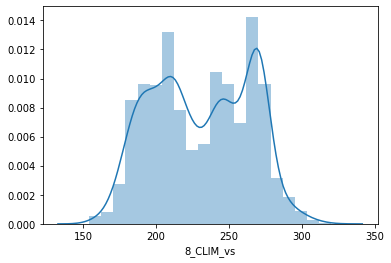

9_S2_B1
4.3667039702634955


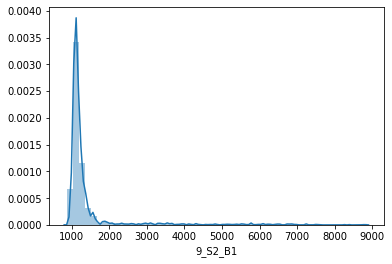

9_S2_B2
4.409722364211209


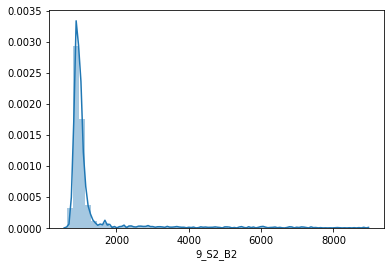

9_S2_B3
4.426532039693957


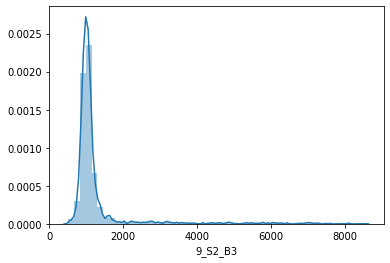

9_S2_B4
4.188197495078745


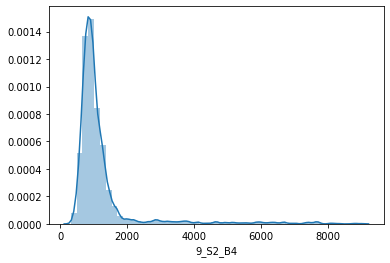

9_S2_B5
4.297827079966262


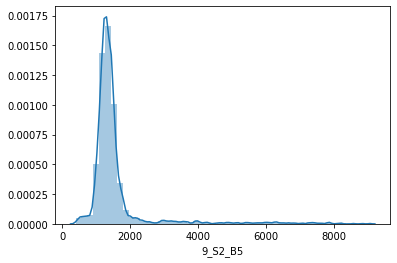

9_S2_B6
3.3038696090208215


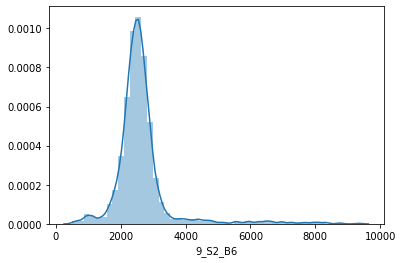

9_S2_B7
2.6707886329606674


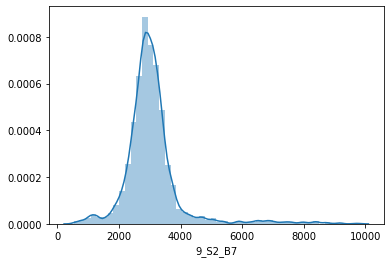

9_S2_B8
2.2332707921332386


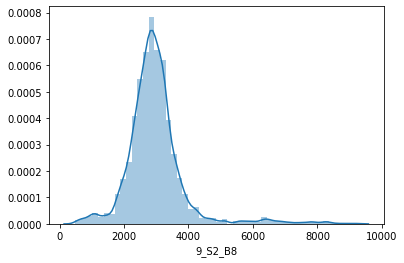

9_S2_B8A
2.330359654184773


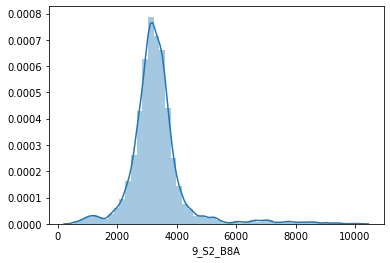

9_S2_B9
2.714071809185223


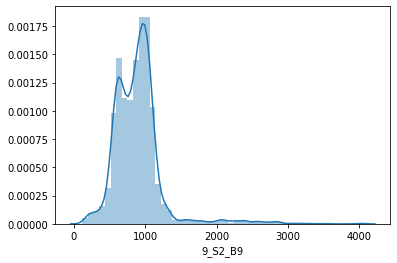

9_S2_B10
6.4509973153879505


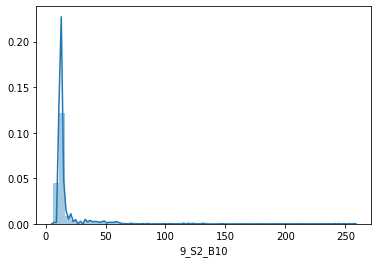

9_S2_B11
2.2108928339970824


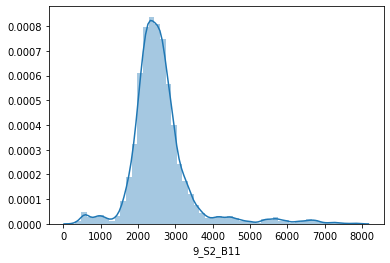

9_S2_B12
2.469786405526417


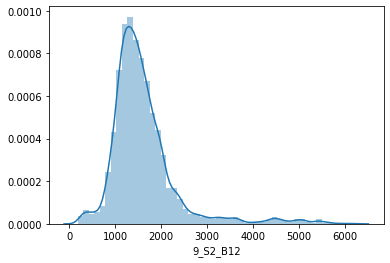

9_CLIM_aet
0.4035041416790002


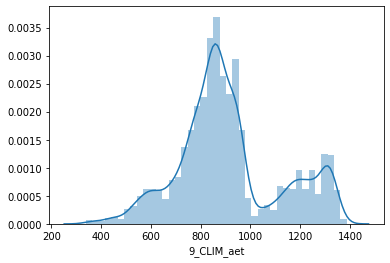

9_CLIM_def
-0.5570319887758752


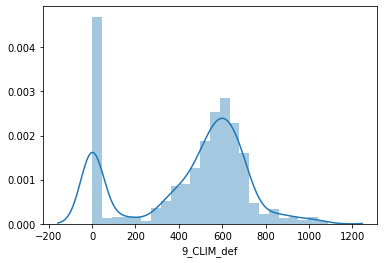

9_CLIM_pet
-0.12810080477941993


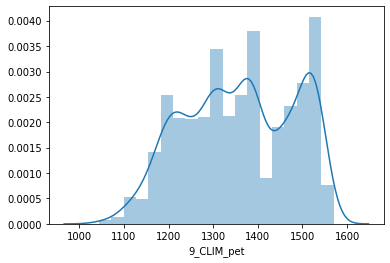

9_CLIM_pr
2.9032497643995288


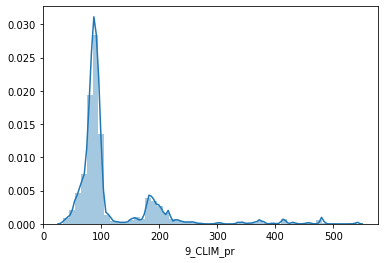

9_CLIM_ro
4.961498507786764


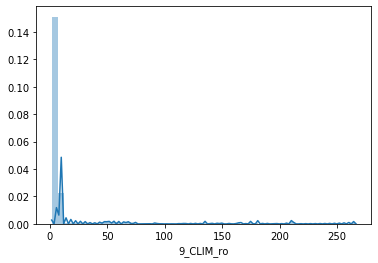

9_CLIM_soil
1.9533551844870083


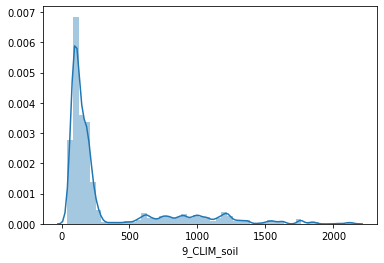

9_CLIM_srad
-0.14580465877082555


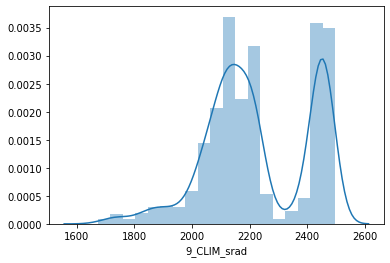

9_CLIM_tmmn
-0.2213808633636462


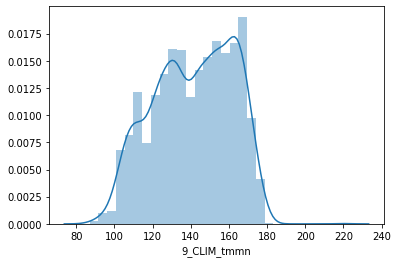

9_CLIM_tmmx
-1.2315826193395831


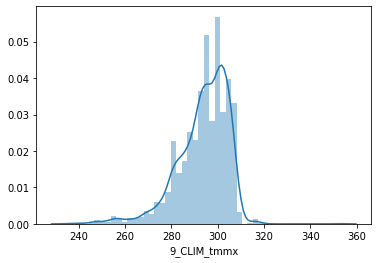

9_CLIM_vap
-0.20592827790786988


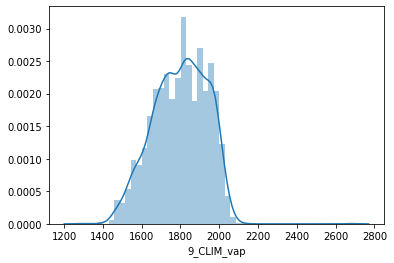

9_CLIM_vpd
-0.41508424888007567


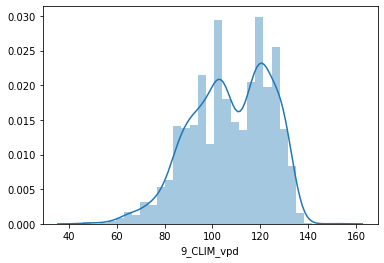

9_CLIM_vs
-0.8342850490073874


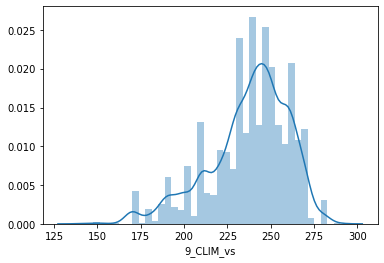

10_S2_B1
5.6922741287913246


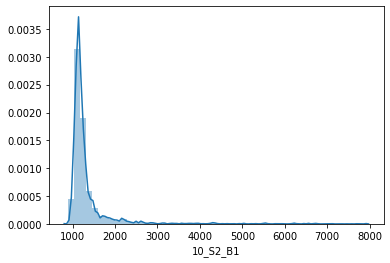

10_S2_B2
6.004766147306474


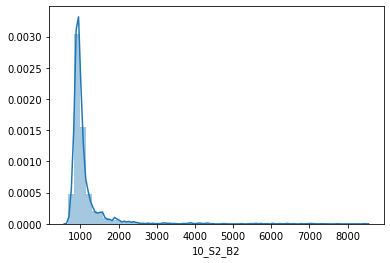

10_S2_B3
6.18261788569732


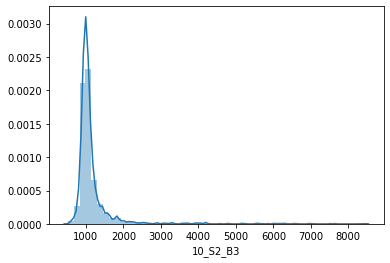

10_S2_B4
5.7346897044792975


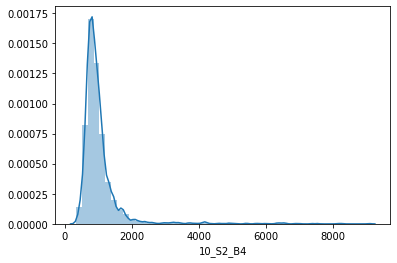

10_S2_B5
6.003708048557971


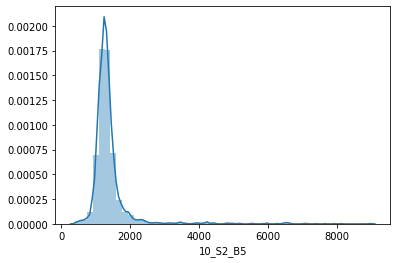

10_S2_B6
4.10339473407684


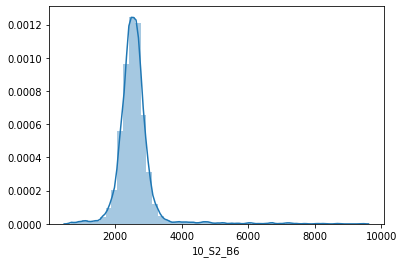

10_S2_B7
2.8663538919638083


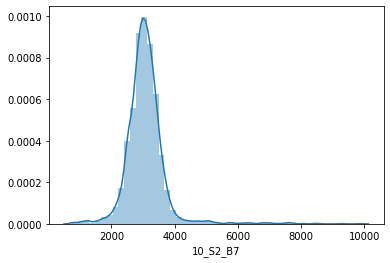

10_S2_B8
2.489324942177796


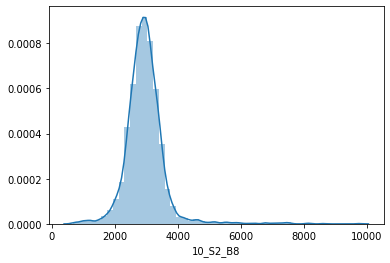

10_S2_B8A
2.3840880737559935


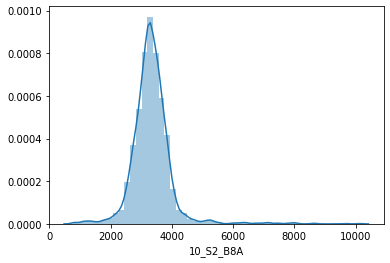

10_S2_B9
4.7201926284736375


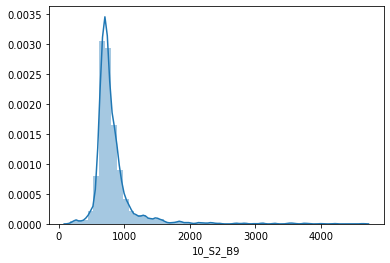

10_S2_B10
6.010736076451881


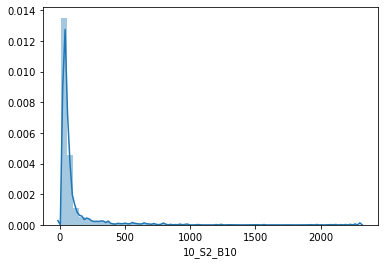

10_S2_B11
2.459335099119556


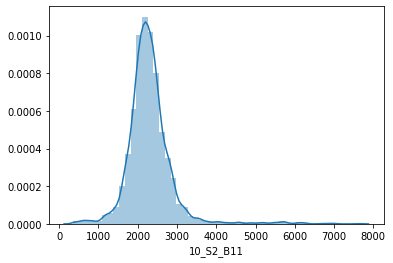

10_S2_B12
2.9347592351839005


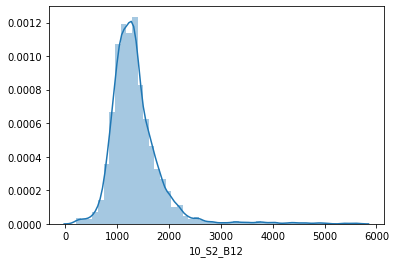

10_CLIM_aet
-0.9157080997065454


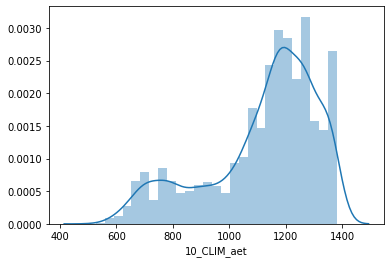

10_CLIM_def
1.1280375405083458


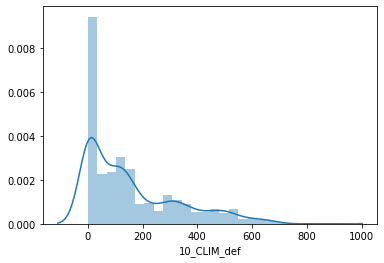

10_CLIM_pet
-0.4791883813858573


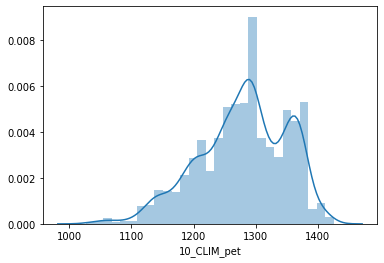

10_CLIM_pr
2.374023007259105


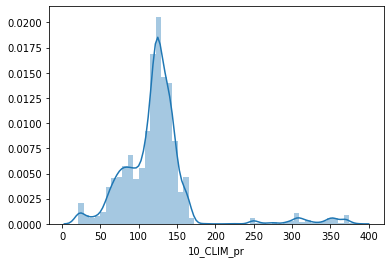

10_CLIM_ro
4.979972329749986


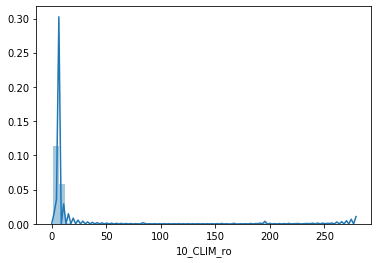

10_CLIM_soil
2.3773056617991966


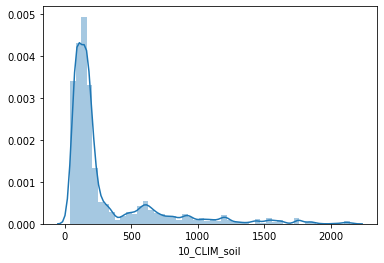

10_CLIM_srad
-0.03782887086580113


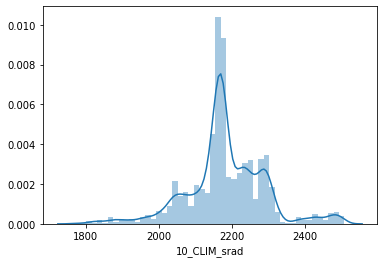

10_CLIM_tmmn
-0.2602611877923123


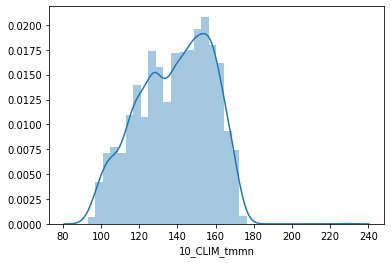

10_CLIM_tmmx
-0.7318947875262652


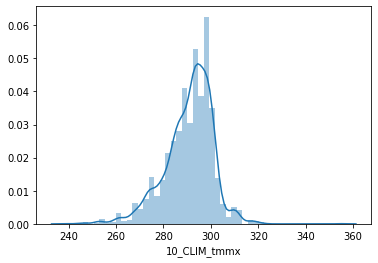

10_CLIM_vap
-0.1386788140198215


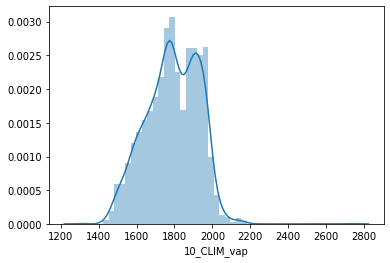

10_CLIM_vpd
0.2627203262929467


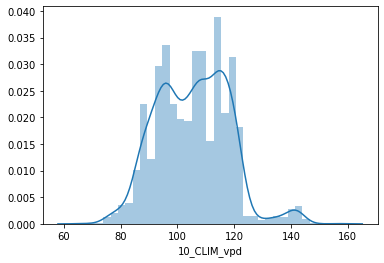

10_CLIM_vs
-0.8528670645517562


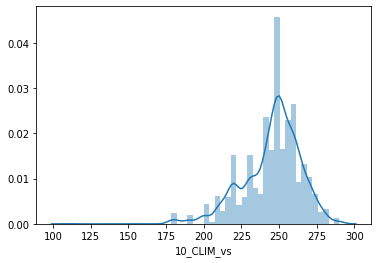

11_S2_B1
4.575950160337279


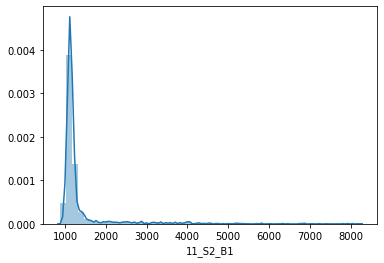

11_S2_B2
4.599353610666603


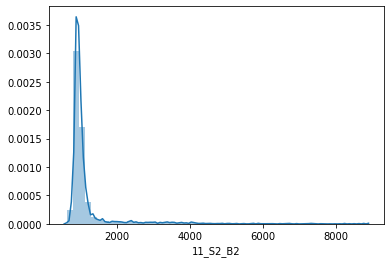

11_S2_B3
4.6555063028462005


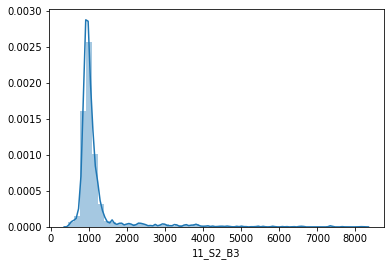

11_S2_B4
4.418835793588622


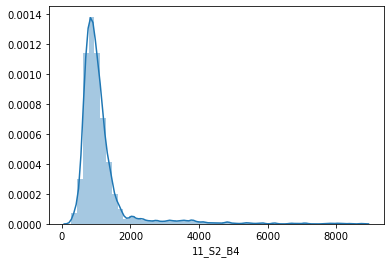

11_S2_B5
4.5474439786536545


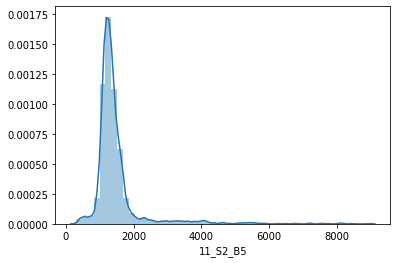

11_S2_B6
3.440330516781861


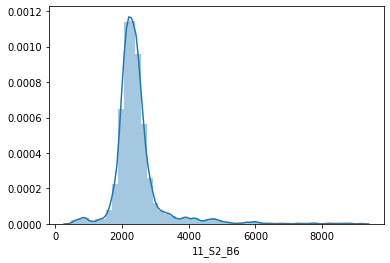

11_S2_B7
2.7249640904271097


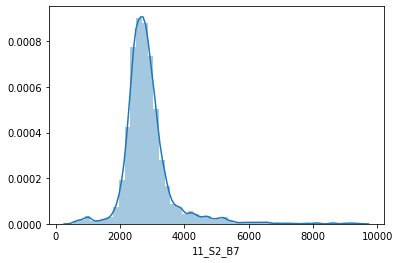

11_S2_B8
2.4624092816771364


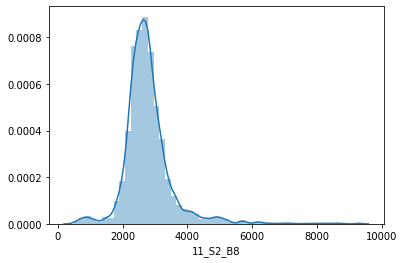

11_S2_B8A
2.368611647765322


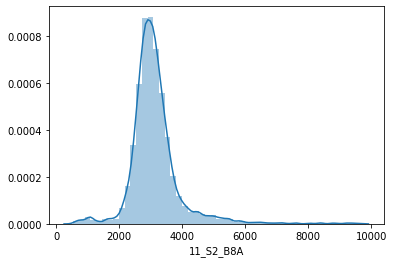

11_S2_B9
4.564353813722821


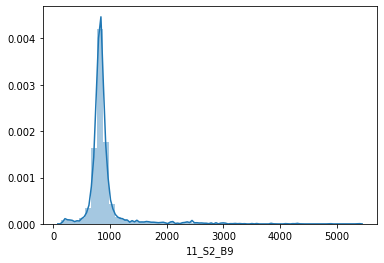

11_S2_B10
2.989854440087519


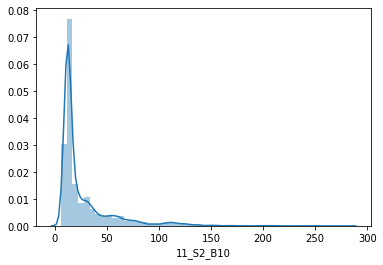

11_S2_B11
1.3754707690601098


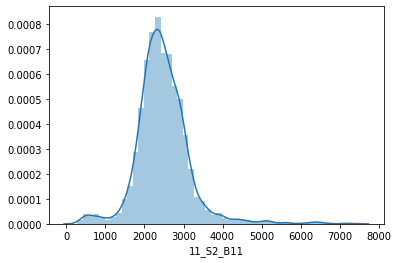

11_S2_B12
1.6237833243030098


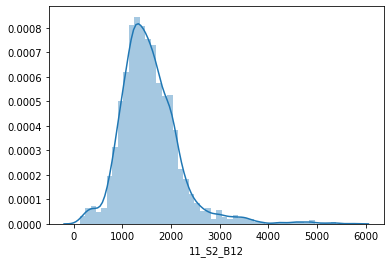

11_CLIM_aet
1.1010221102205369


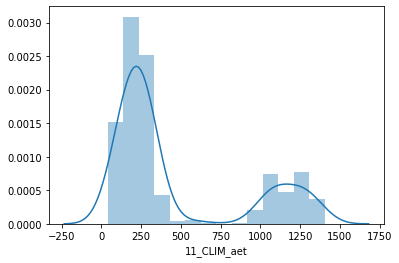

11_CLIM_def
-1.1105666958367675


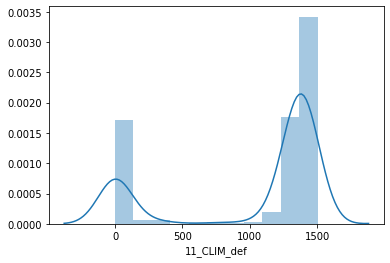

11_CLIM_pet
-1.0654420315812436


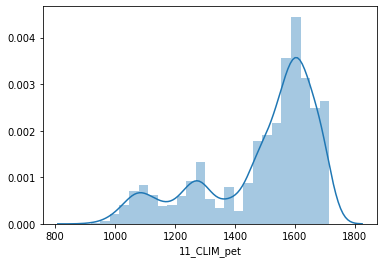

11_CLIM_pr
1.3821454032780573


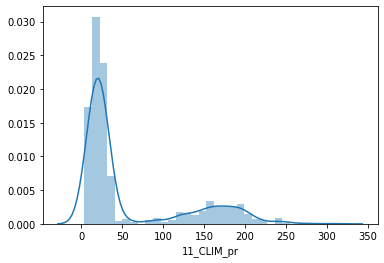

11_CLIM_ro
4.303289143552878


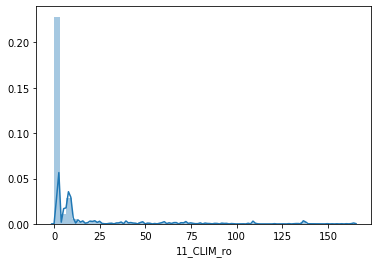

11_CLIM_soil
1.7798422387934334


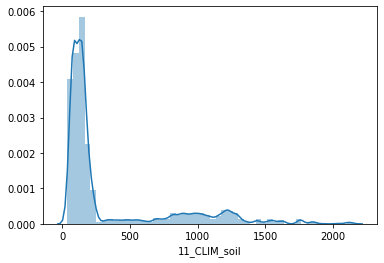

11_CLIM_srad
-1.39265197336816


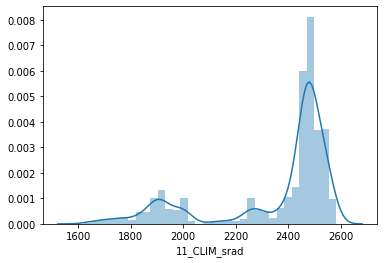

11_CLIM_tmmn
-0.24922376661564974


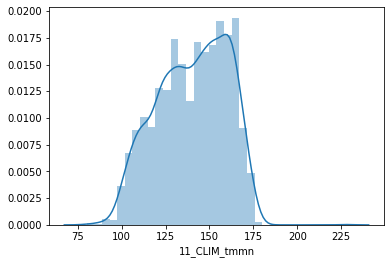

11_CLIM_tmmx
-1.0896970585840595


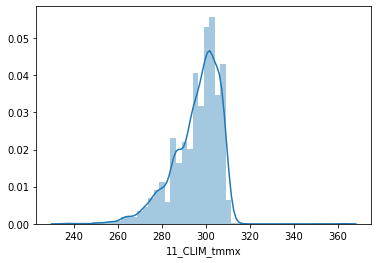

11_CLIM_vap
0.3040933296013155


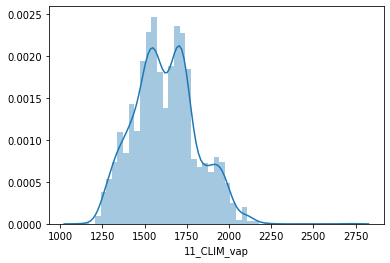

11_CLIM_vpd
-1.3801265566231264


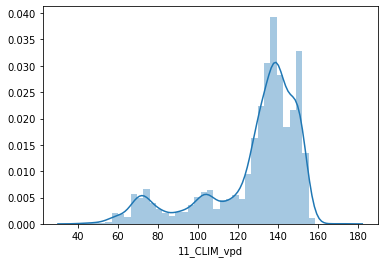

11_CLIM_vs
-0.7867385315478482


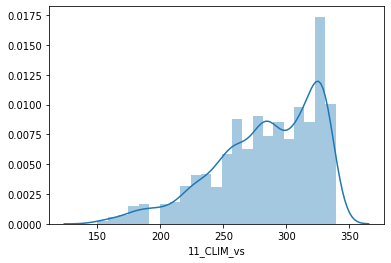

In [177]:
from scipy.stats import skew
import seaborn as sns
from matplotlib import pyplot as plt
x, y  = train_sampled[train_sampled1.columns[:-2]], train_sampled1['Yield']
for col in x:
    print(col)
    print(skew(x[col]))
    plt.figure()
    sns.distplot(x[col])
    plt.show()


In [178]:
skewness = x.skew()
print(skewness)

0_S2_B1         7.043604
0_S2_B2         5.709805
0_S2_B3         3.593708
0_S2_B4         0.863172
0_S2_B5         0.990880
                  ...   
11_CLIM_tmmn   -0.249349
11_CLIM_tmmx   -1.090246
11_CLIM_vap     0.304247
11_CLIM_vpd    -1.380822
11_CLIM_vs     -0.787135
Length: 302, dtype: float64


In [179]:
 corr_skew = pd.read_csv('Corr_Skew.csv')

In [180]:
labels = []
for n in range(len(corr_skew)):
    if (corr_skew['Skew'][n] > 0.49) and (corr_skew['Correlation'][n] > 0.099) :
        labels.append(corr_skew['Bands'][n])
    if (corr_skew['Skew'][n] > 0.49) and (corr_skew['Correlation'][n] < -0.099) :
        labels.append(corr_skew['Bands'][n])
print(labels)

['0_S2_B4', '0_CLIM_pr', '0_CLIM_ro', '0_CLIM_soil', '1_CLIM_srad', '1_CLIM_vpd', '2_S2_B1', '2_S2_B2', '2_S2_B3', '2_S2_B4', '2_S2_B5', '2_S2_B6', '2_S2_B7', '2_S2_B8', '2_S2_B8A', '2_S2_B11', '3_S2_B1', '3_S2_B2', '3_S2_B3', '3_S2_B4', '3_S2_B5', '3_S2_B6', '3_S2_B7', '3_S2_B8', '3_S2_B8A', '3_CLIM_ro', '4_CLIM_pr', '5_CLIM_pr', '5_CLIM_ro', '6_S2_B7', '6_S2_B8', '6_S2_B8A', '6_S2_B9', '6_CLIM_pr', '6_CLIM_ro', '7_S2_B9', '7_CLIM_pr', '7_CLIM_ro', '7_CLIM_soil', '8_S2_B11', '8_S2_B12', '8_CLIM_def', '8_CLIM_soil', '9_S2_B1', '9_S2_B2', '9_S2_B3', '9_S2_B4', '10_S2_B10', '10_CLIM_def', '10_CLIM_pr', '10_CLIM_ro', '11_S2_B9']


In [181]:
print(len(labels))

52


Changing the skewness using sqaureroot transformation

In [182]:
X1 = x.copy()
for i in labels:
    X1[i] = np.sqrt(X1[i])  
skewness = X1.skew()
print(skewness)

0_S2_B1         7.043604
0_S2_B2         5.709805
0_S2_B3         3.593708
0_S2_B4         0.276117
0_S2_B5         0.990880
                  ...   
11_CLIM_tmmn   -0.249349
11_CLIM_tmmx   -1.090246
11_CLIM_vap     0.304247
11_CLIM_vpd    -1.380822
11_CLIM_vs     -0.787135
Length: 302, dtype: float64


In [183]:
"""for i in labels:
    print(i)
    print(skew(train_sampled1[i]))
    plt.figure()
    sns.distplot(train_sampled1[i])
    plt.show()"""

'for i in labels:\n    print(i)\n    print(skew(train_sampled1[i]))\n    plt.figure()\n    sns.distplot(train_sampled1[i])\n    plt.show()'

0_S2_B4
0.2759775163292416


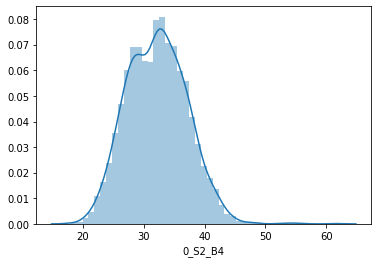

0_CLIM_pr
0.448148494815651


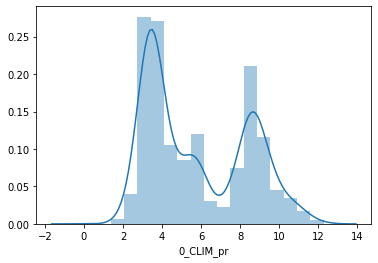

0_CLIM_ro
-0.24226642920735725


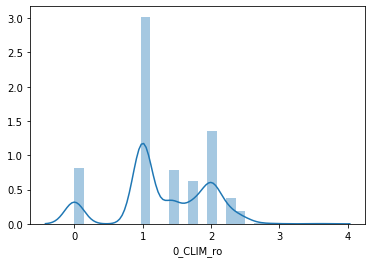

0_CLIM_soil
0.349132965548651


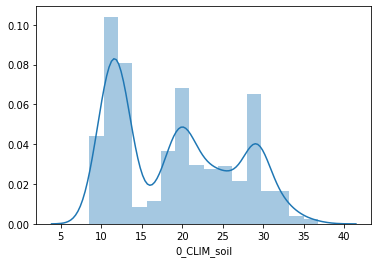

1_CLIM_srad
0.7480403744545482


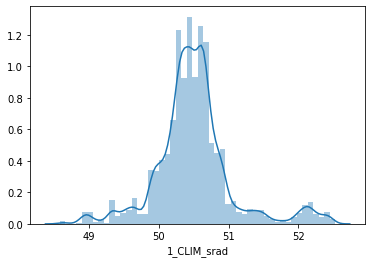

1_CLIM_vpd
1.698182219331615


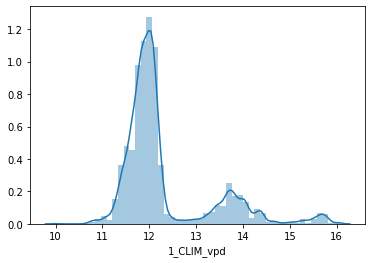

2_S2_B1
3.2547071444132345


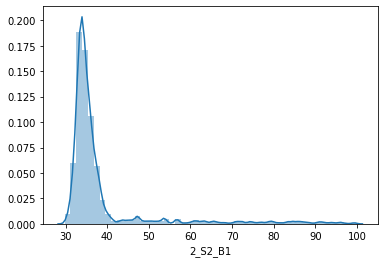

2_S2_B2
3.291823193061218


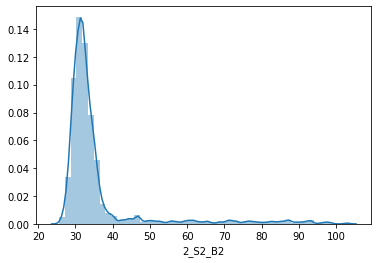

2_S2_B3
3.2101476127926154


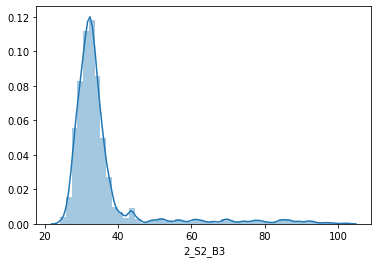

2_S2_B4
2.8767503726986257


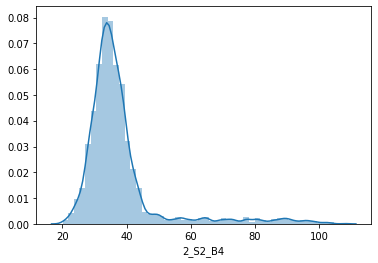

2_S2_B5
3.0386961853320162


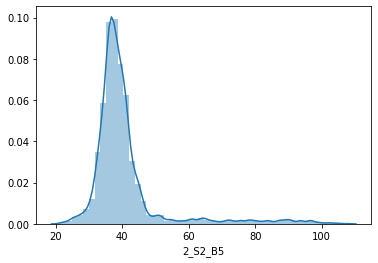

2_S2_B6
2.5049015114251647


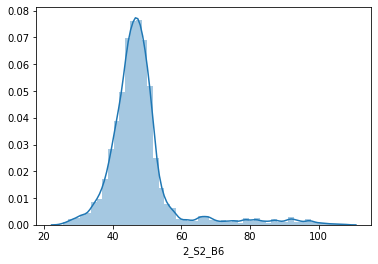

2_S2_B7
2.1875416660861533


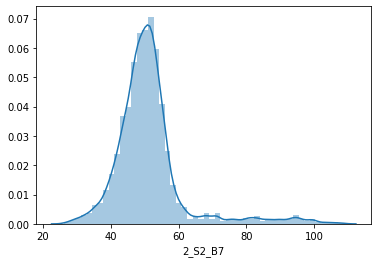

2_S2_B8
2.0212889911391927


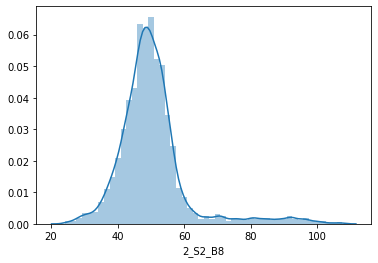

2_S2_B8A
1.9492289315971303


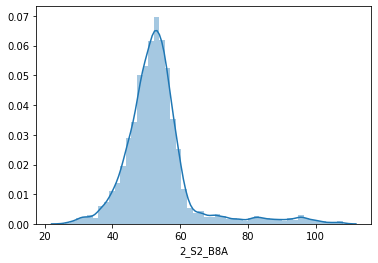

2_S2_B11
0.524932654616738


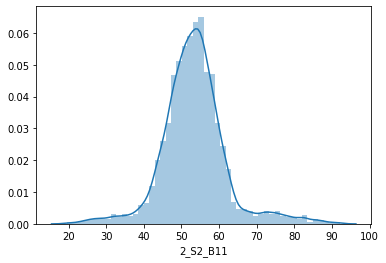

3_S2_B1
2.289280351844873


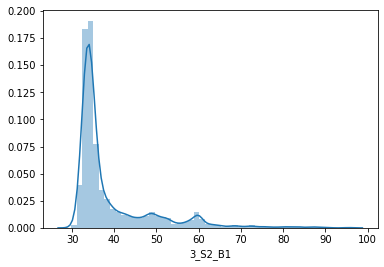

3_S2_B2
2.3404869492241045


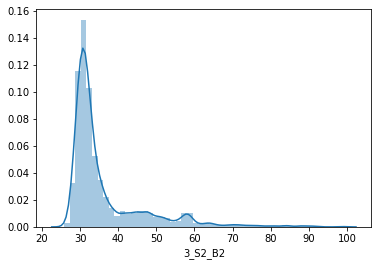

3_S2_B3
2.3967570739837987


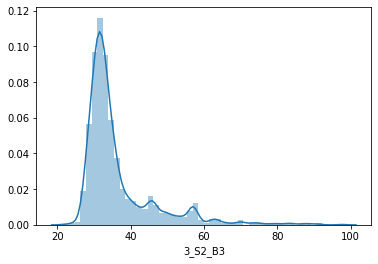

3_S2_B4
2.237236554298471


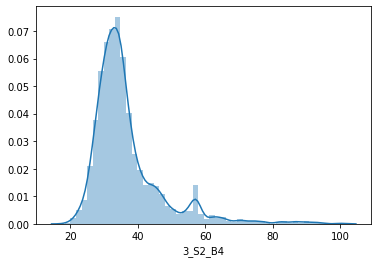

3_S2_B5
2.442762908972202


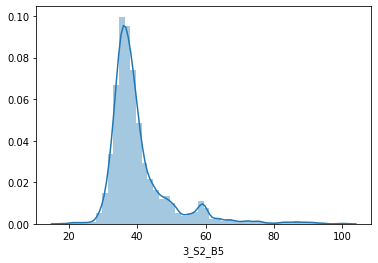

3_S2_B6
1.665105069892848


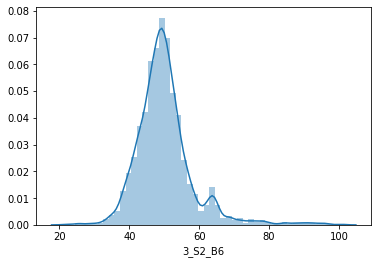

3_S2_B7
1.2618724207811998


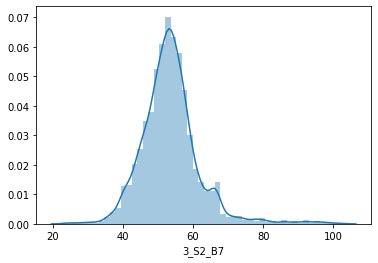

3_S2_B8
1.1508473485616795


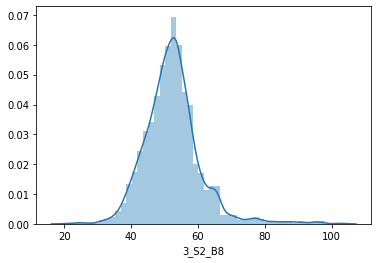

3_S2_B8A
1.0911782603503573


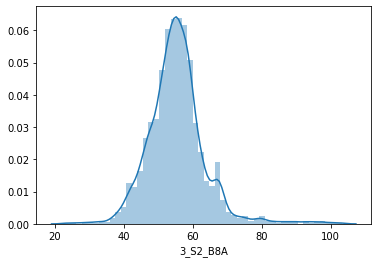

3_CLIM_ro
0.729679697367522


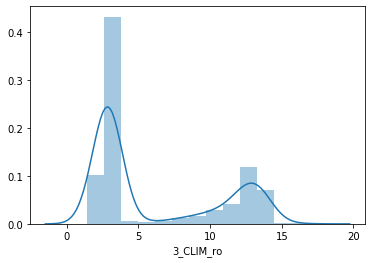

4_CLIM_pr
2.3721823126641253


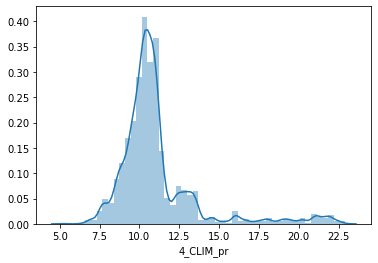

5_CLIM_pr
2.5836826816538645


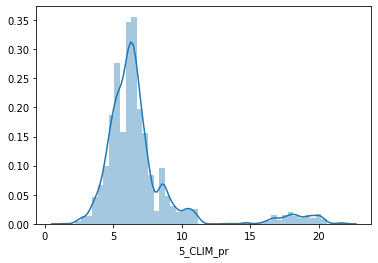

5_CLIM_ro
3.7142955299468077


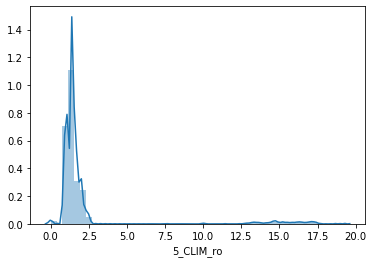

6_S2_B7
1.5310211497459025


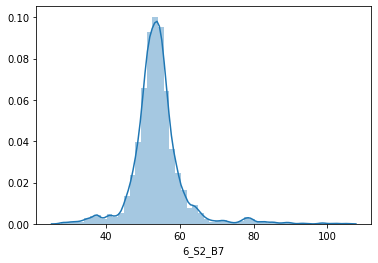

6_S2_B8
1.3431788580990642


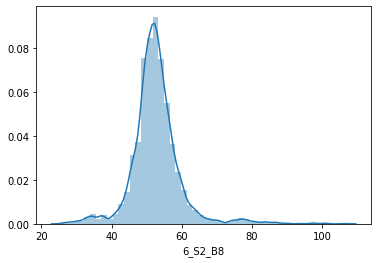

6_S2_B8A
1.1101432277803134


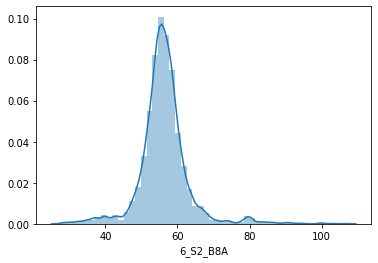

6_S2_B9
3.524979566697377


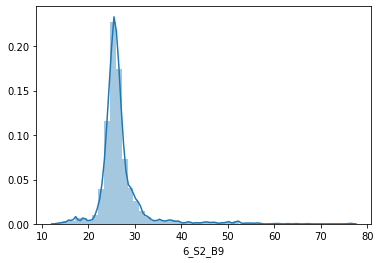

6_CLIM_pr
0.5174802087110506


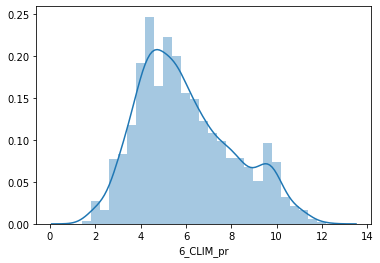

6_CLIM_ro
2.079394140049593


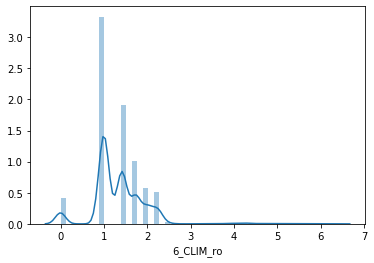

7_S2_B9
3.526450320687818


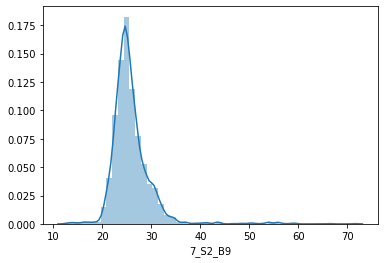

7_CLIM_pr
0.8637942489211333


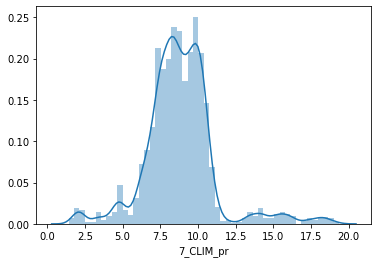

7_CLIM_ro
4.237404777557848


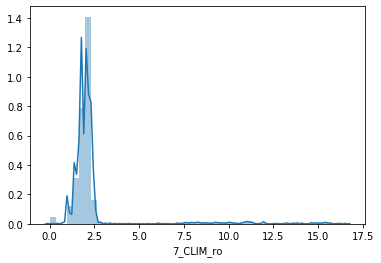

7_CLIM_soil
2.1391773749690364


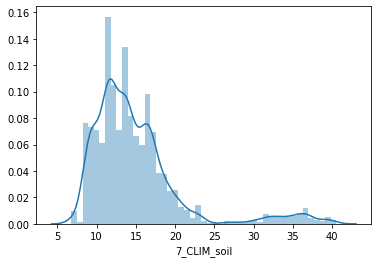

8_S2_B11
0.695833735417322


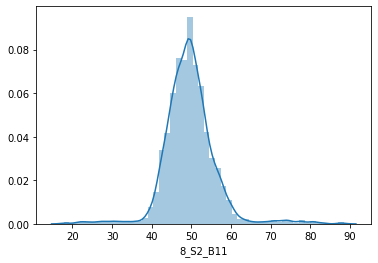

8_S2_B12
1.0300183921371797


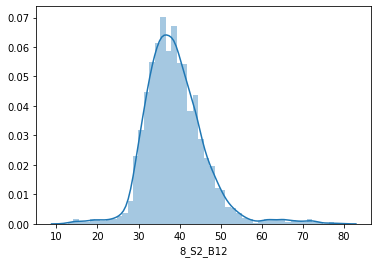

8_CLIM_def
-0.4017562929458273


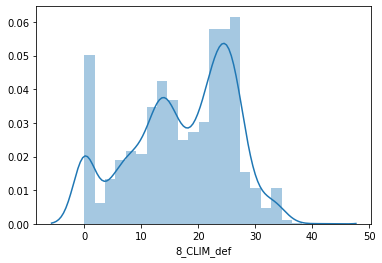

8_CLIM_soil
2.524118810552502


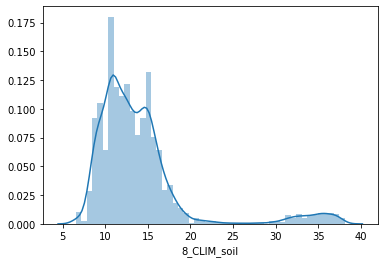

9_S2_B1
3.7287969013666267


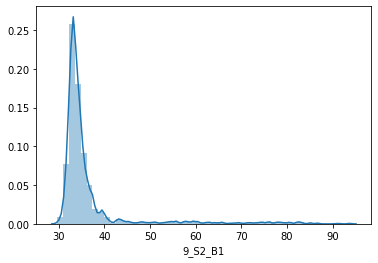

9_S2_B2
3.6889154619333113


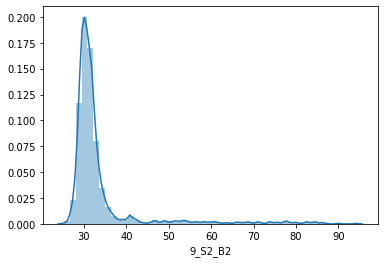

9_S2_B3
3.637697794057252


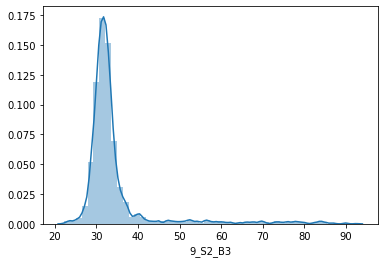

9_S2_B4
3.089516612643757


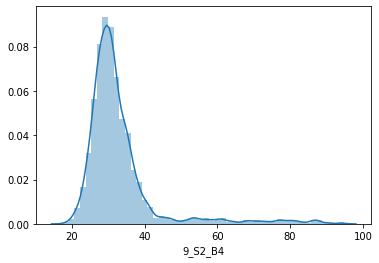

10_S2_B10
2.9335364190746276


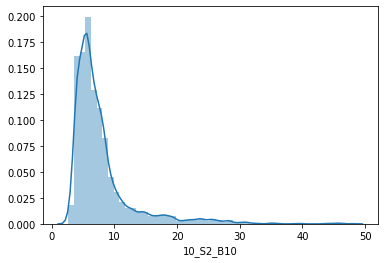

10_CLIM_def
0.14889286929009907


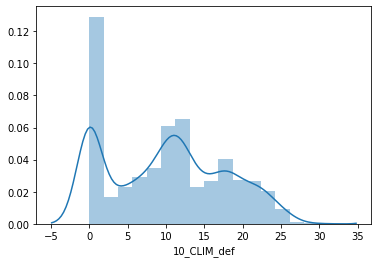

10_CLIM_pr
0.8665213043419755


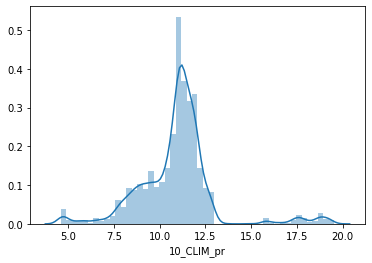

10_CLIM_ro
4.588942324356654


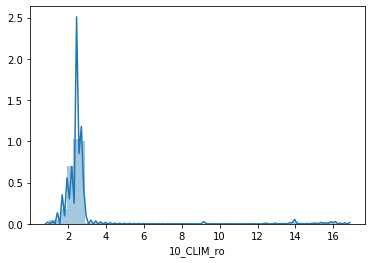

11_S2_B9
2.65900825301068


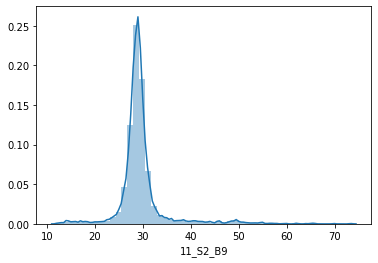

In [184]:
for i in labels:
    print(i)
    print(skew(X1[i]))
    plt.figure()
    sns.distplot(X1[i])
    plt.show()

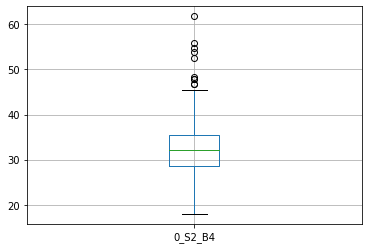

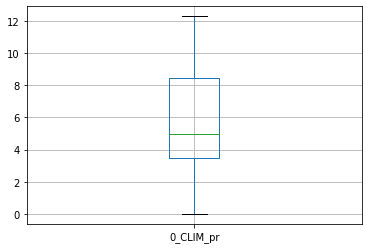

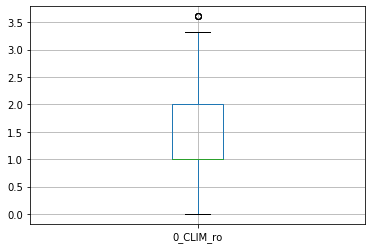

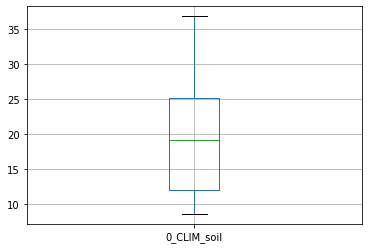

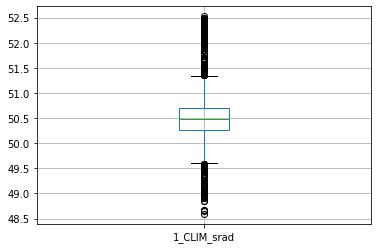

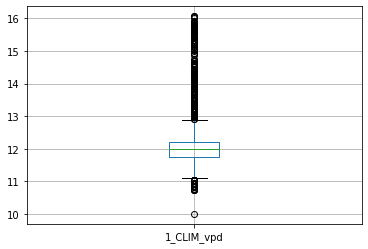

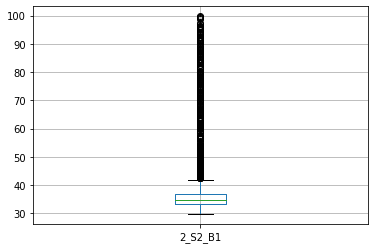

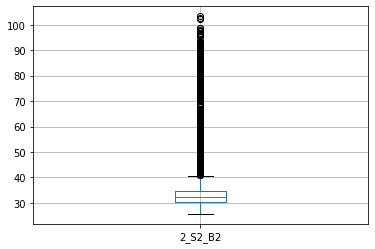

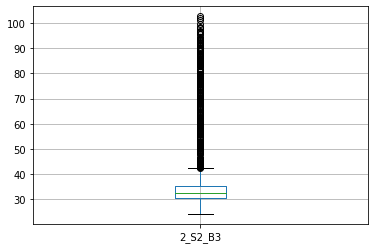

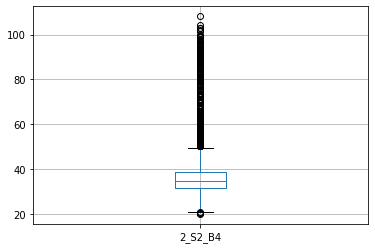

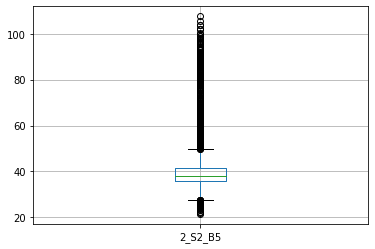

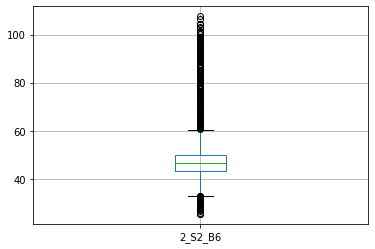

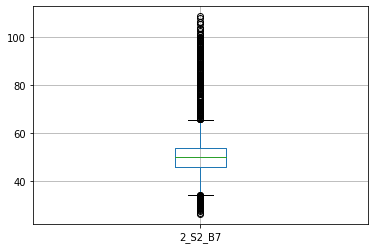

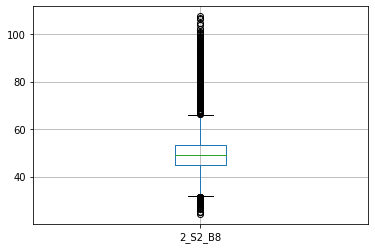

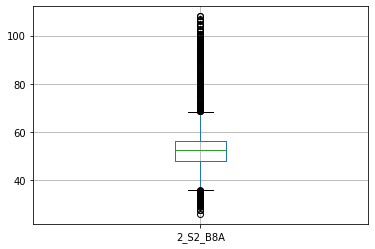

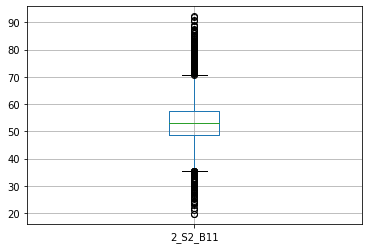

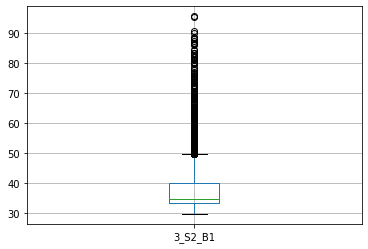

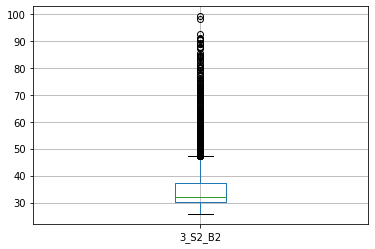

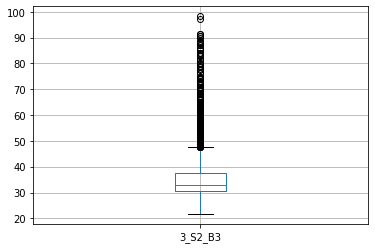

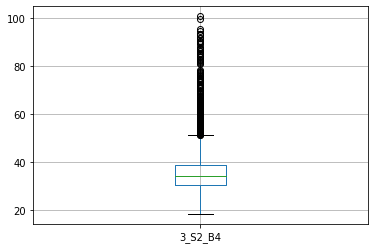

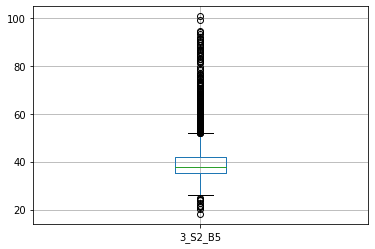

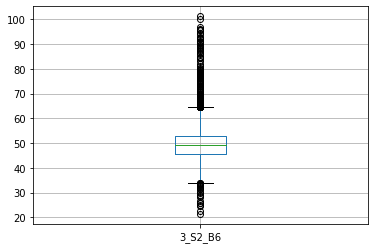

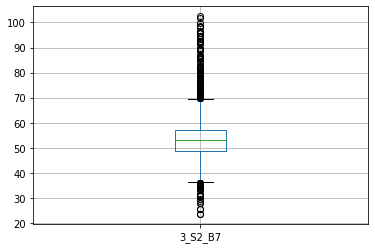

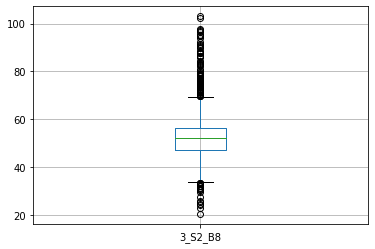

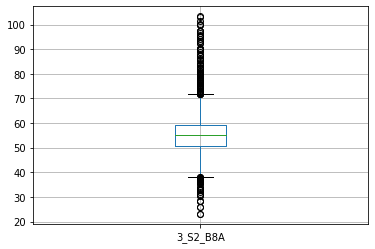

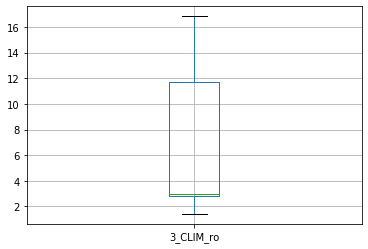

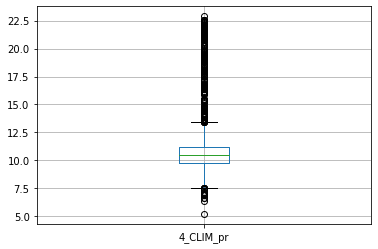

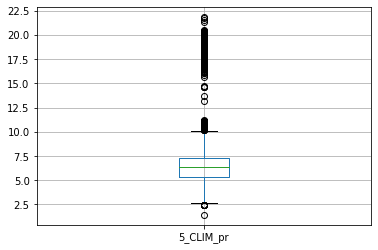

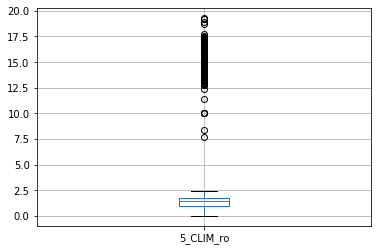

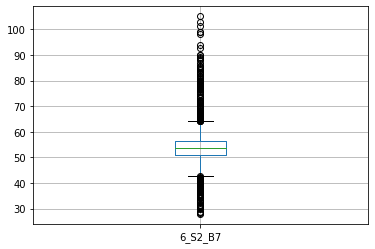

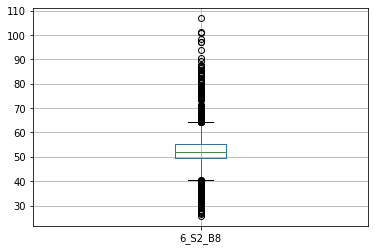

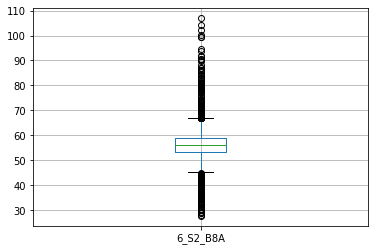

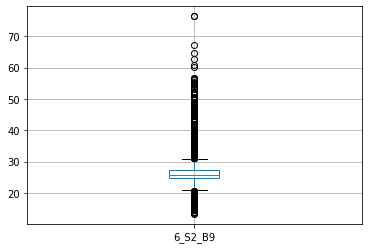

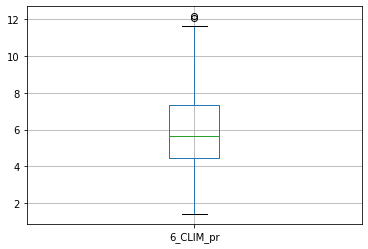

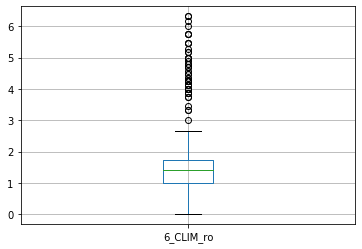

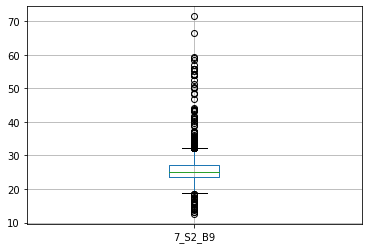

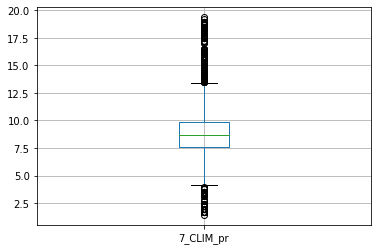

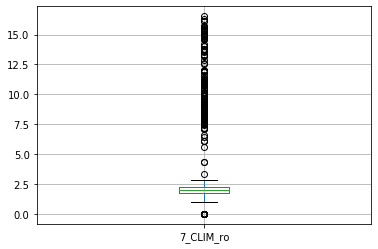

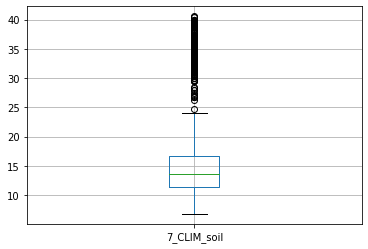

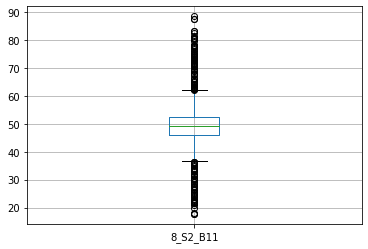

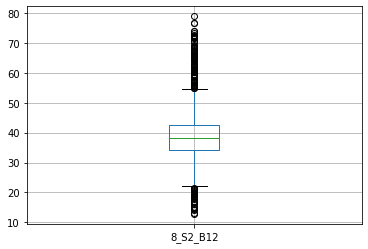

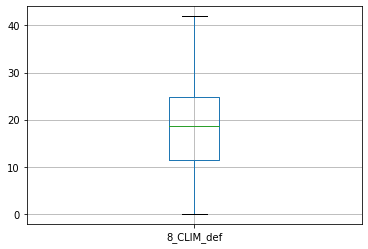

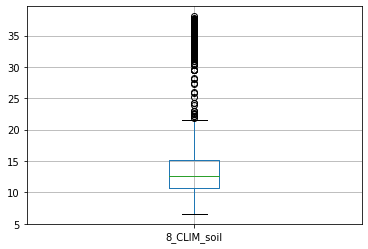

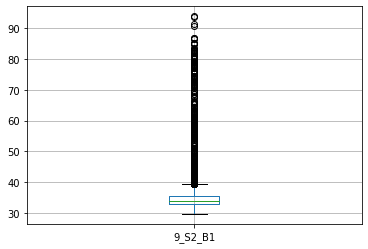

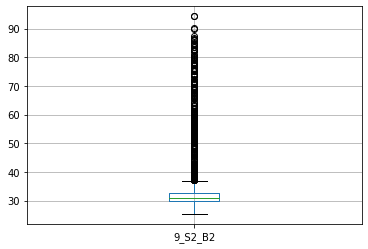

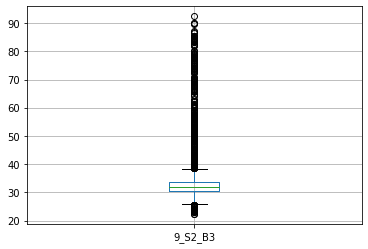

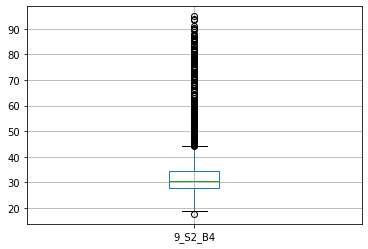

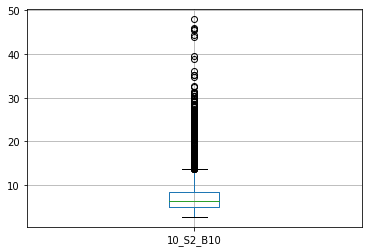

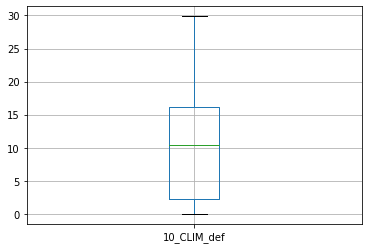

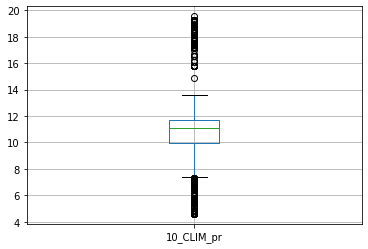

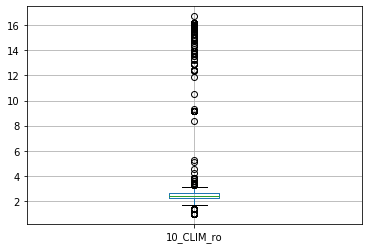

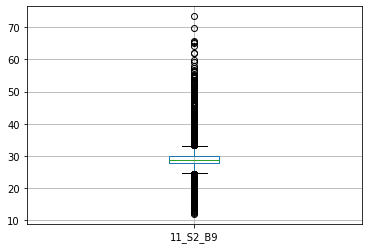

In [185]:
for i in labels:
    X1.boxplot(column = i)
    plt.show()

From the above boxplot graph we can observe that after applying squareroot transformation we can see that there is outliers.

In [187]:
X2 = x.copy()
for i in labels:
    X2[i] = (X2[i])**(1./3.)
print("-----------original skweness-----------")
for i in labels:
    print(i)
    print(skew(x[i]))
print("-----------Change in skewness-----------")
for i in labels:
    print(i)
    print(skew(X2[i]))

-----------original skweness-----------
0_S2_B4
0.8627374042278938
0_CLIM_pr
0.7968129938663439
0_CLIM_ro
1.0381869697957216
0_CLIM_soil
0.7293938649595825
1_CLIM_srad
0.8172176509838925
1_CLIM_vpd
1.8696998240473175
2_S2_B1
3.8265811862174512
2_S2_B2
3.9233486634121055
2_S2_B3
3.9209726552545385
2_S2_B4
3.805462344026427
2_S2_B5
3.8767788525394864
2_S2_B6
3.5137521758898655
2_S2_B7
3.246715551551924
2_S2_B8
3.1606177549593832
2_S2_B8A
3.0369362939205944
2_S2_B11
1.6058005318075343
3_S2_B1
3.0923133893308417
3_S2_B2
3.3320971666056156
3_S2_B3
3.483220102394451
3_S2_B4
3.574854368167452
3_S2_B5
3.60936892162944
3_S2_B6
2.9189745220127925
3_S2_B7
2.490523069912837
3_S2_B8
2.3796773979746204
3_S2_B8A
2.3182358089845723
3_CLIM_ro
0.8843056600809972
4_CLIM_pr
3.1207212915430476
5_CLIM_pr
3.431050328662907
5_CLIM_ro
3.9824638188636197
6_S2_B7
3.1109190221606426
6_S2_B8
2.9744304967938193
6_S2_B8A
2.716481009753802
6_S2_B9
5.759551489365558
6_CLIM_pr
1.1133520138031017
6_CLIM_ro
6.69938040093

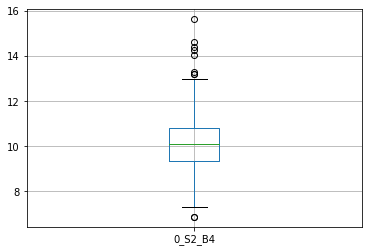

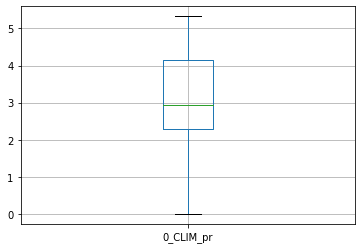

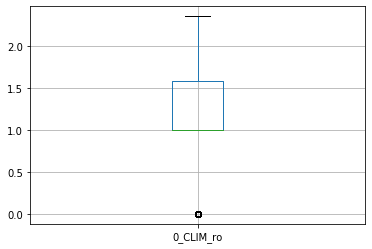

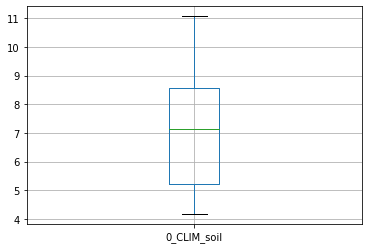

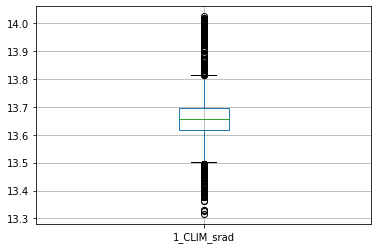

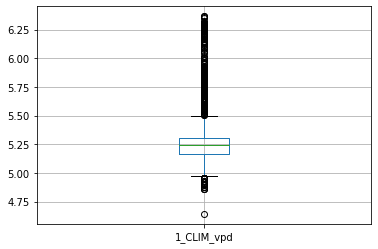

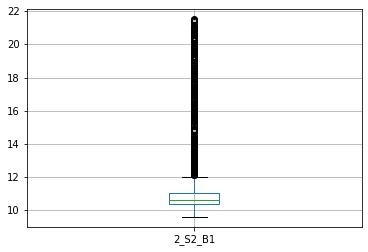

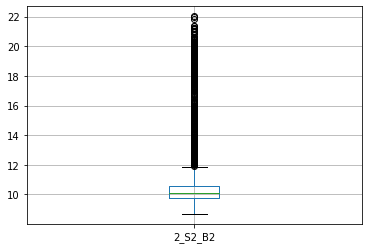

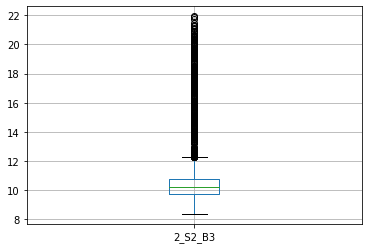

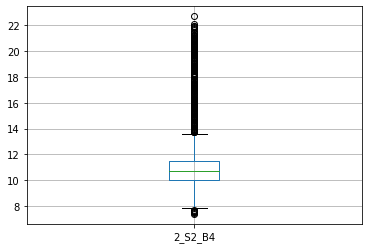

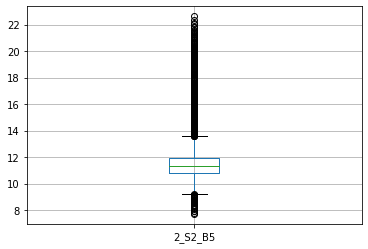

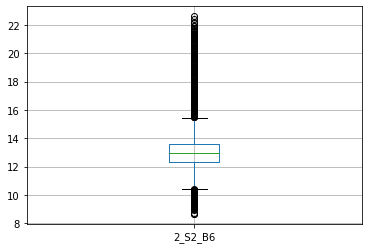

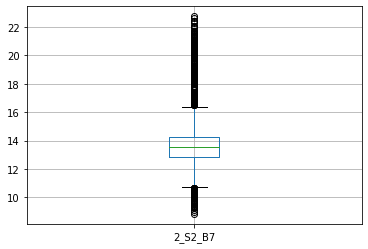

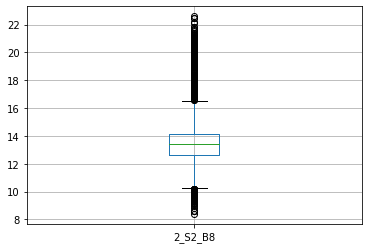

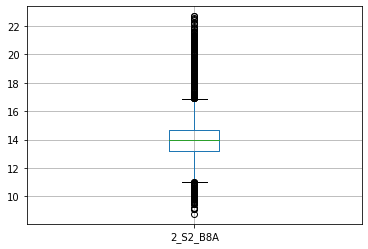

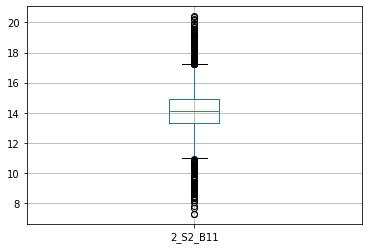

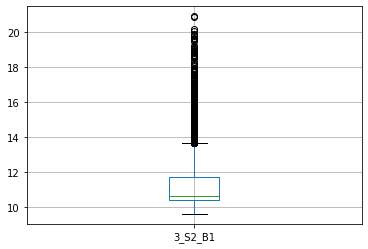

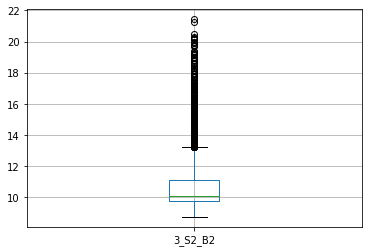

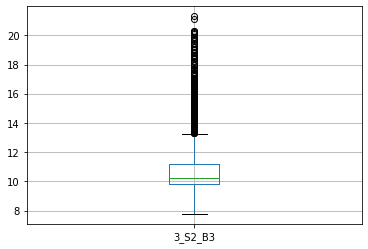

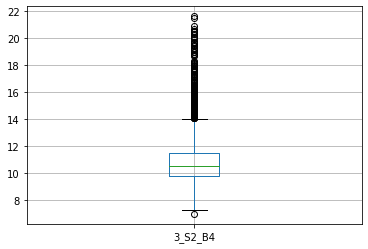

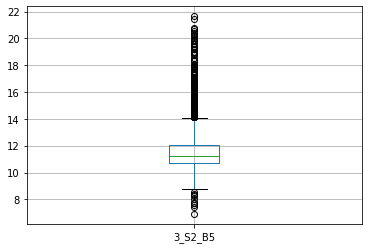

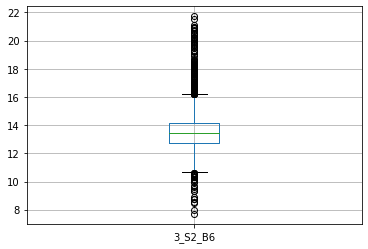

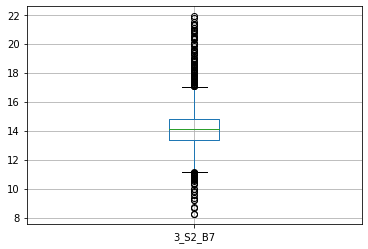

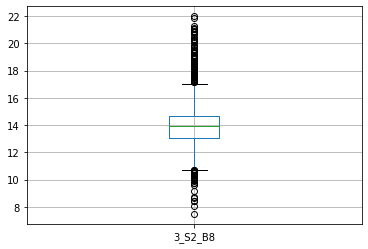

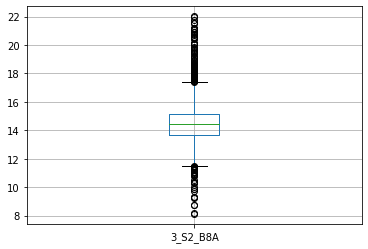

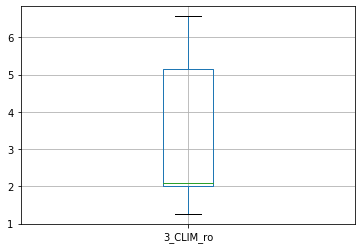

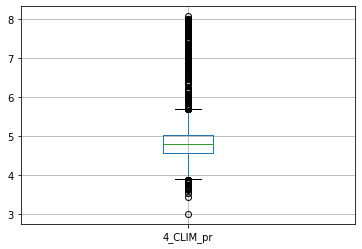

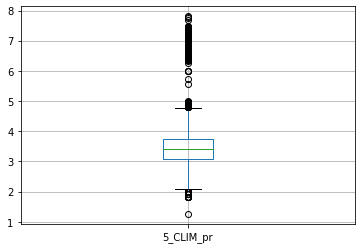

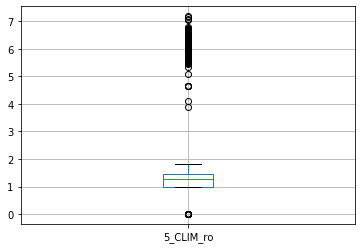

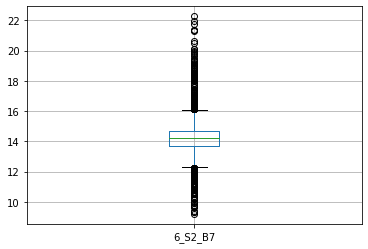

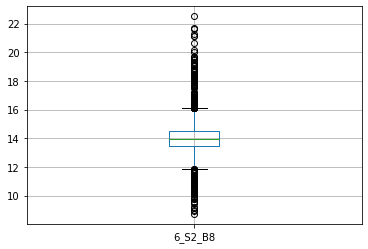

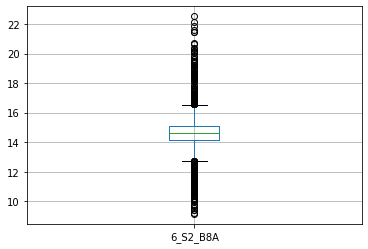

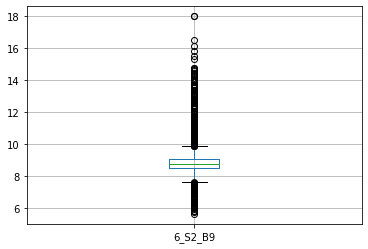

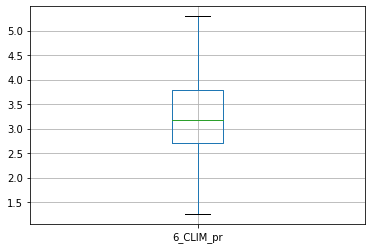

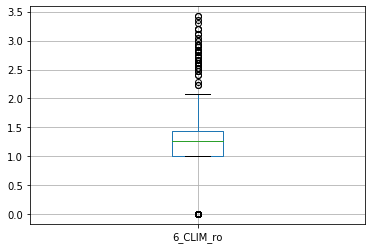

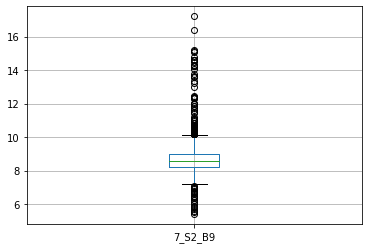

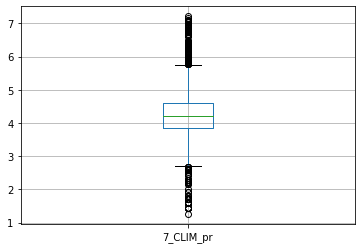

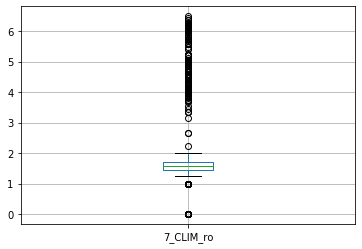

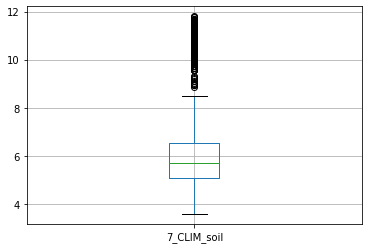

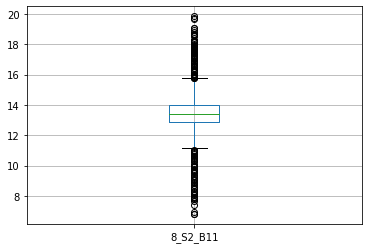

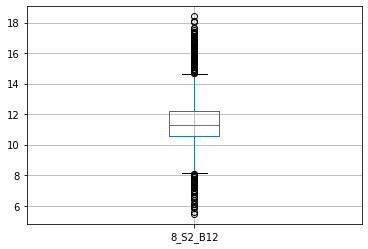

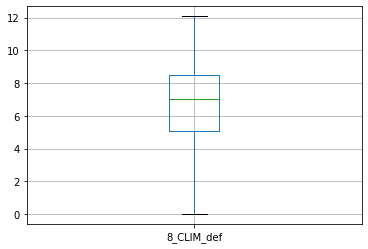

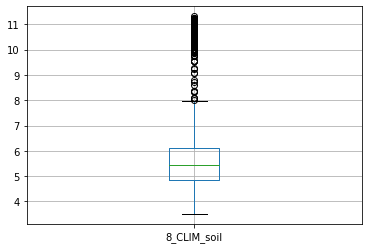

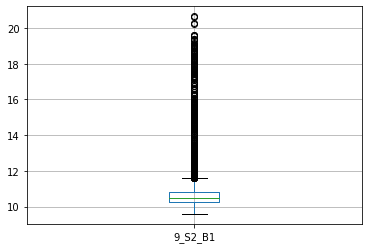

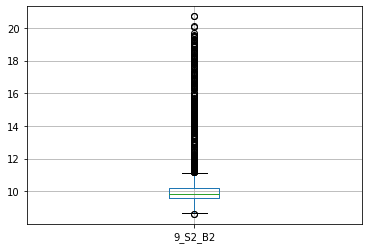

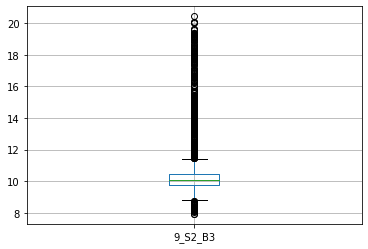

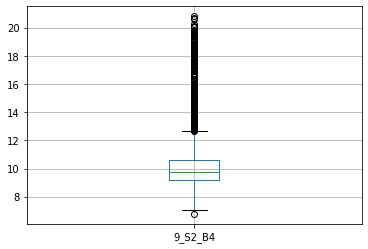

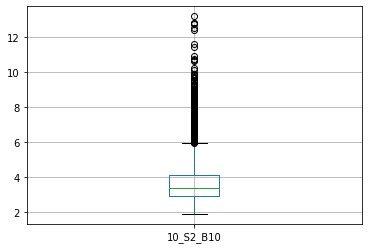

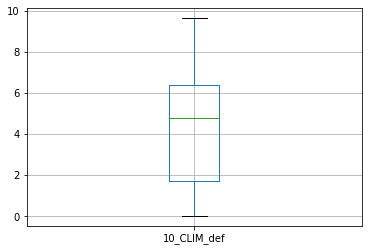

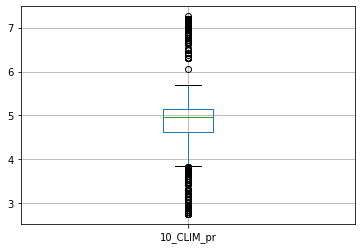

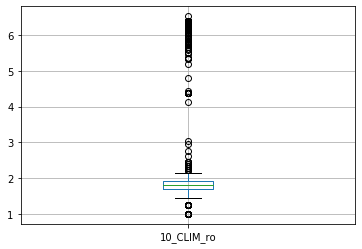

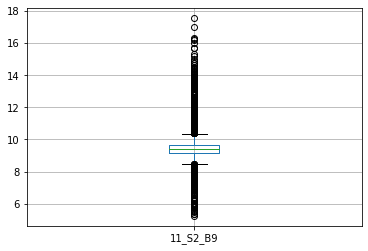

In [188]:
for i in labels:
    X2.boxplot(column = i)
    plt.show()

In [189]:
X3 = x.copy()
for i in labels:
    X3[i] = np.log10(X3[i])

print("-----------Change in skewness-----------")
for i in labels:
    print(i)
    print(skew(X2[i]))

-----------Change in skewness-----------
0_S2_B4
0.11460422531169996
0_CLIM_pr
0.32798583836231493
0_CLIM_ro
-1.030859365204628
0_CLIM_soil
0.2279911039600228
1_CLIM_srad
0.7248917150661687
1_CLIM_vpd
1.6432578935793498
2_S2_B1
3.0722363291375525
2_S2_B2
3.0798766078136963
2_S2_B3
2.9621529679268934
2_S2_B4
2.526958179746743
2_S2_B5
2.724140815465622
2_S2_B6
2.127083236454168
2_S2_B7
1.8038276807577052
2_S2_B8
1.6154114765844534
2_S2_B8A
1.5585630402552657
2_S2_B11
0.12691895663913066
3_S2_B1
2.0845447272690745
3_S2_B2
2.0893674120892856
3_S2_B3
2.110305656187448
3_S2_B4
1.8607551759236844
3_S2_B5
2.1071650195547904
3_S2_B6
1.2796885244998246
3_S2_B7
0.8898564581405256
3_S2_B8
0.783666623392113
3_S2_B8A
0.7160884818687334
3_CLIM_ro
0.6796746385068779
4_CLIM_pr
2.0906831487908453
5_CLIM_pr
2.1751182317518998
5_CLIM_ro
3.5085797106068526
6_S2_B7
1.030344918939702
6_S2_B8
0.8402810306012439
6_S2_B8A
0.5982477263377567
6_S2_B9
2.864248021365181
6_CLIM_pr
0.2842208361008189
6_CLIM_ro
0.0161

/opt/anaconda3/lib/python3.7/site-packages/pandas/core/series.py:679: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


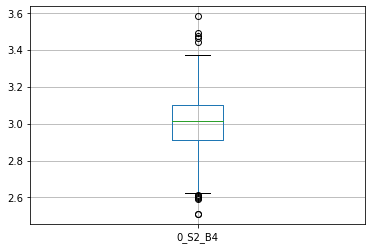

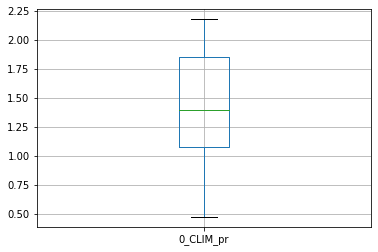

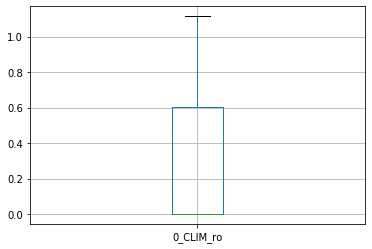

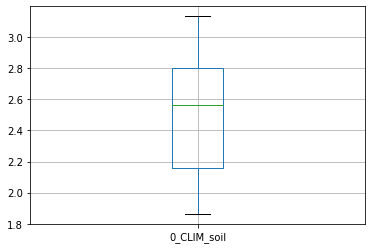

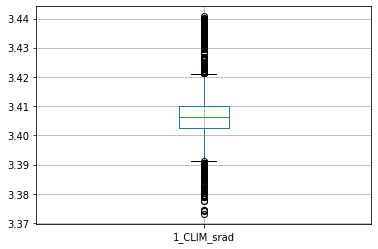

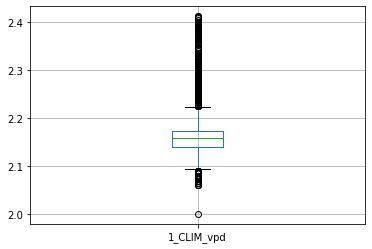

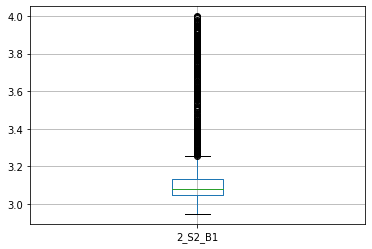

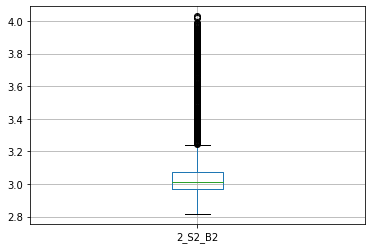

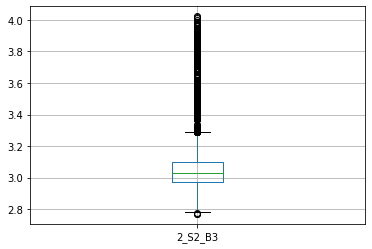

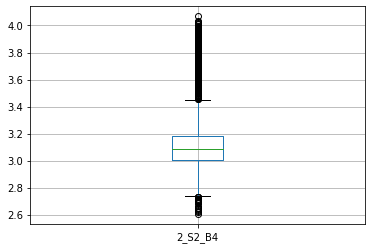

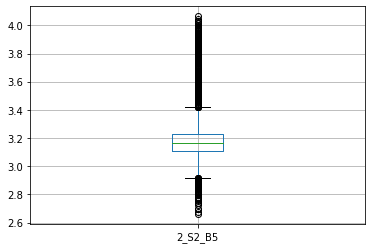

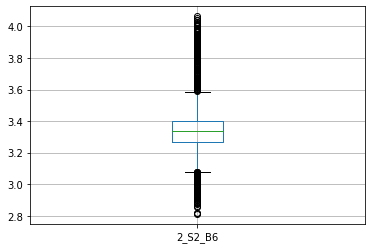

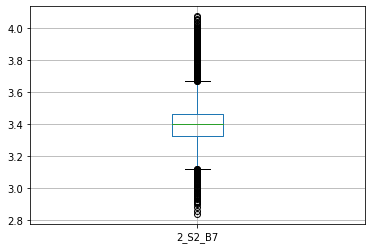

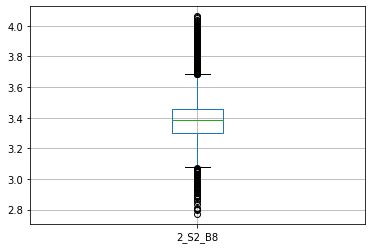

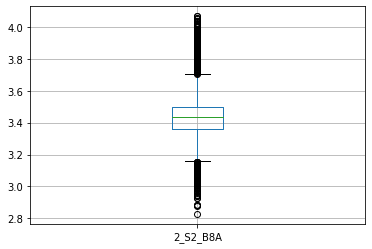

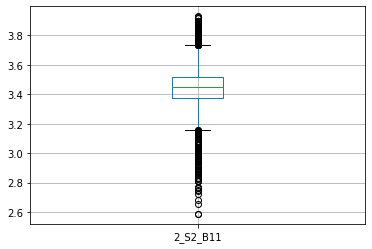

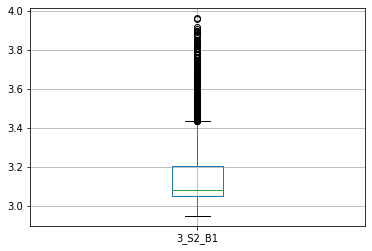

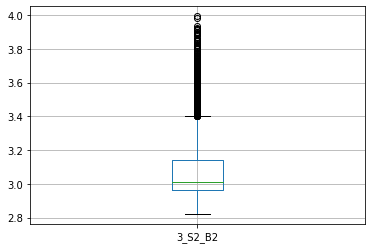

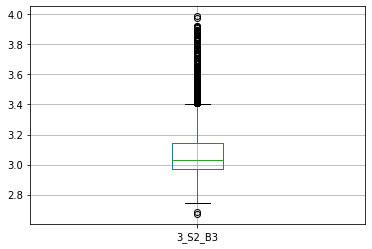

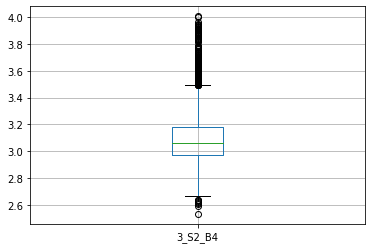

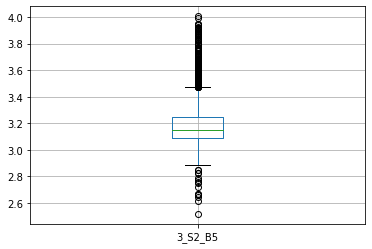

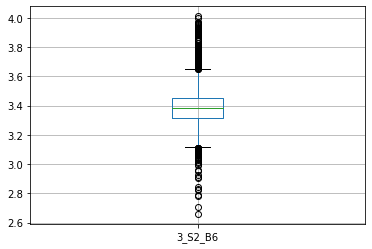

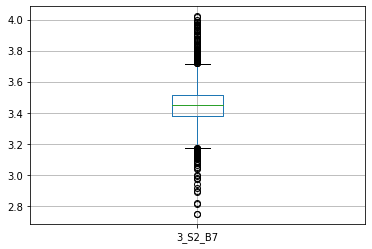

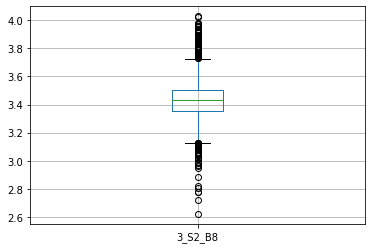

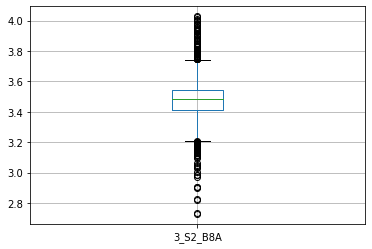

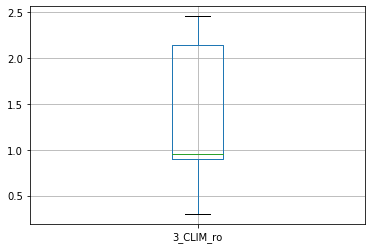

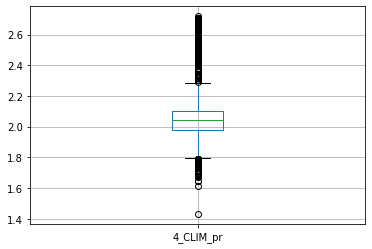

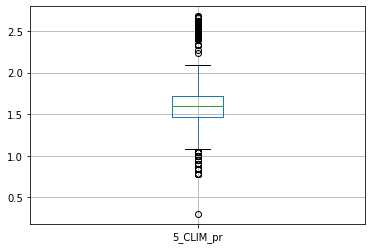

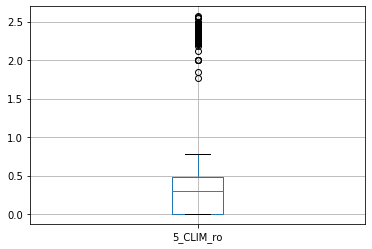

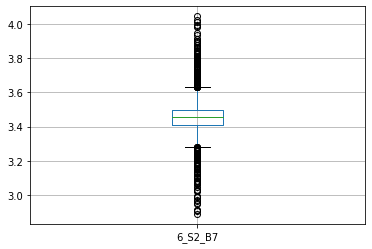

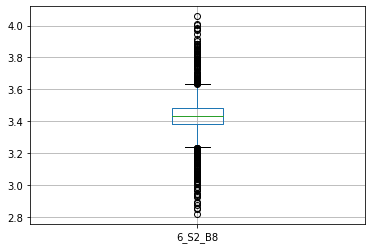

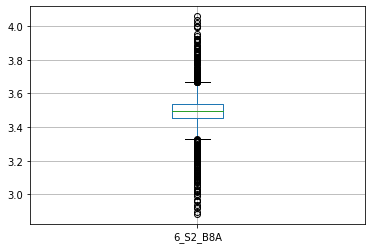

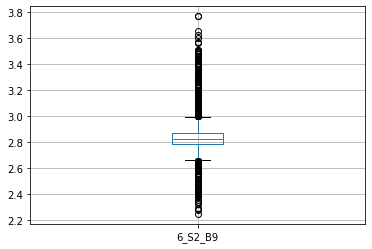

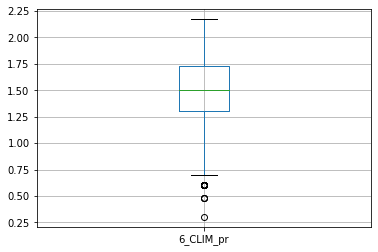

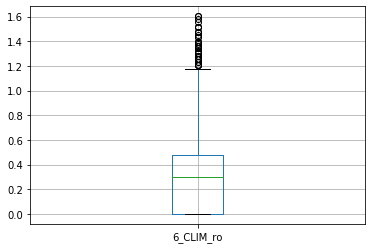

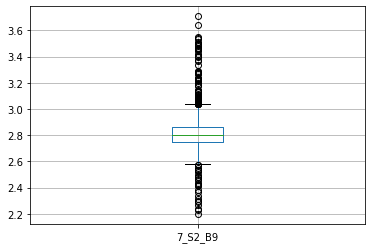

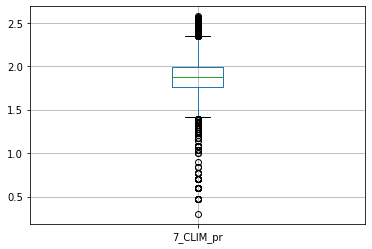

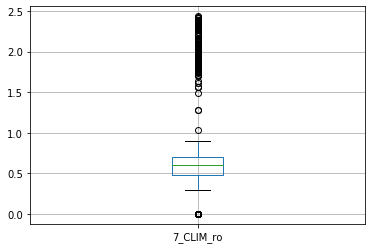

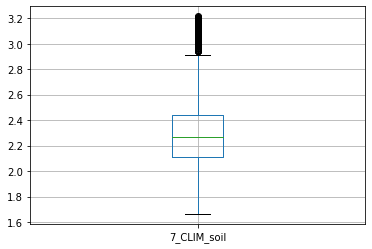

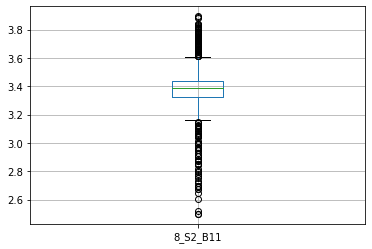

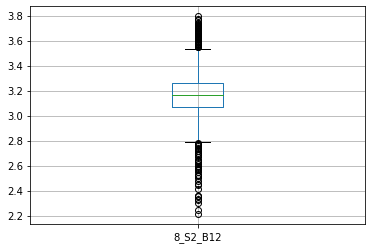

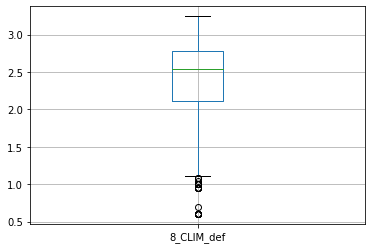

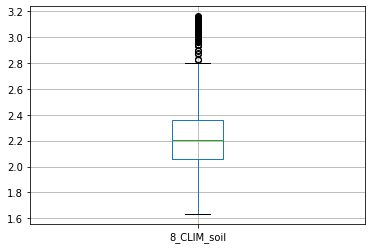

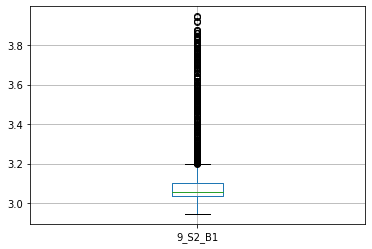

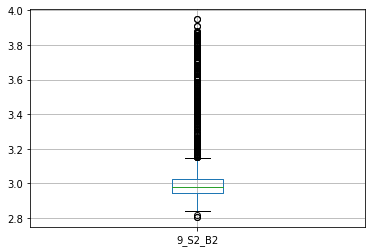

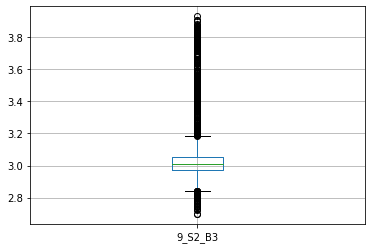

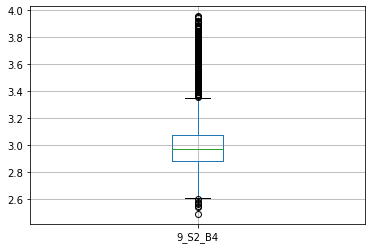

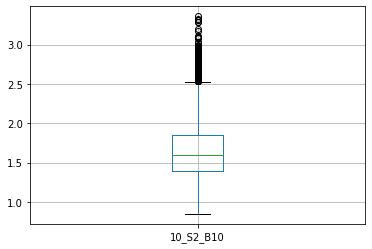

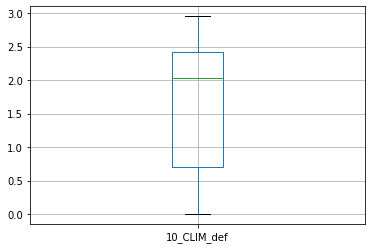

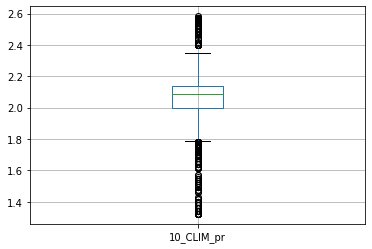

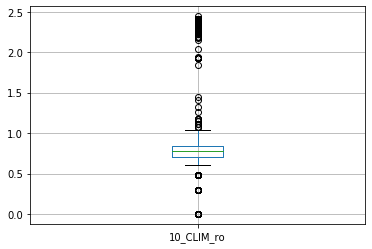

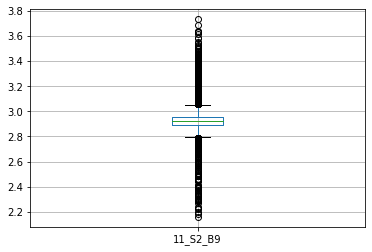

In [190]:
for i in labels:
    X3.boxplot(column = i)
    plt.show()

# Fitting a model

Now that we have a way to get features from the inputs, we can fit a model and see how it does:

Score: 1.5603917740976232


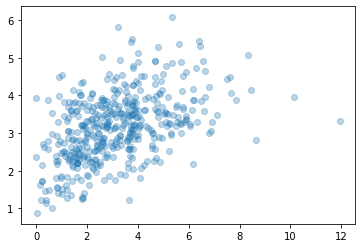

In [98]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Split the data
#X, y  = train_sampled[train_sampled.columns[:-2]], train_sampled['Yield']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15)

# Fit the model
model = RandomForestRegressor()
model.fit(X_train, y_train)

# Score with RMSE
print('Score:', mean_squared_error(y_test, model.predict(X_test), squared=False))

# Plot pred vs actual for the test set:
plt.scatter(y_test, model.predict(X_test), alpha=0.3)

# Saving Preds

Once we're happy with how we generate our inputs, we must process the test fields in the same way and save predictions. Here it is, condensed. Note the Field_IDs from the sample submission are used, and the same `process_im` function prepares the inputs, this time looking for .npy files in the 'image_arrays_test' folder. 

In [99]:
# Load the sample submission file
ss = pd.read_csv('SampleSubmission.csv')

# Prep the data, using the same method we did for train
test_sampled = pd.DataFrame([process_im(fid, folder='image_arrays_test') for fid in ss['Field_ID'].values])

#Extracting features required
test_sampled1 = test_sampled.dropna(axis=1)

uniquevalue1 = []

print(uniquevalue1)
type(uniquevalue1)

for i in test_sampled1.columns:
    if test_sampled1[i].nunique() == 1:
        del test_sampled1[i]

#del train_sampled1['Field_ID']
test_sampled1.drop(columns = ['0_S2_QA60','1_S2_QA60','2_S2_QA60','3_S2_QA60','3_CLIM_def','3_CLIM_pdsi','4_S2_QA60','5_S2_QA60','6_S2_QA60','7_S2_QA60','8_S2_QA60','9_S2_QA60','10_S2_QA60','11_S2_QA60','4_CLIM_pdsi', '5_CLIM_pdsi', '6_CLIM_pdsi', '7_CLIM_pdsi','8_CLIM_pdsi', '9_CLIM_pdsi', '10_CLIM_pdsi', '11_CLIM_pdsi'], inplace=True)

test_sampled1.shape


# Get model predictions
preds = model.predict(test_sampled1)

# Store them in the submission dataframe and save
ss['Yield'] = preds
ss.to_csv('Sub.csv', index=False)
ss.head()

[]


Field_ID     Yield
0  E9UZCEA  3.683157
1  1WGGS1Q  3.498417
2  EG2KXE2  3.799313
3  HC3GQXF  3.250787
4  7AK6GFK  3.334100

You can submit the Sub.csv file generated here on Zindi. This example scores ~2 (not as good as our score on our local test set, because the fields are more geographically separated). Now let's chat about ways to make this better:

# Improvements


1.   For the example above I chose the 'bands of interest' fairly randomly. A bit of research into which Sentinel 2 bands are used in this kind of task and what the different climate variables are should help make more informed choices there.
2.   We looked at all 12 months. Maize is normally planted just before the March-May rainy season (I think?) and harvested a few months later. Choose which months you'll prioritise to cut down on less useful data
3.   We looked at only the center pixel. Can you use a wider area to get better features? What about finding which pixels are most likely fields and sampling those?
4.   We did no model tuning, so obviously lots of fun to be had there
5.   Low-quality locations are often not fields - leave these out of your training set for better results. There are no low-quality (Quality=1) fields in the test set.
6.   Common measures such as NDVI, EVI etc can be computed by combining different bands. Look up how these vegetative indices are calculated for sentinel 2 and see if you can add those as features.
6.   ... As always, be creative - I'm sure there are lots more improvements to be made

